In [765]:
%load_ext autoreload

%autoreload 2

%matplotlib inline

from __future__ import print_function, division

import os
import numpy as np
import eos_integrate
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", dpi=144)
import scipy.optimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


rho_c:	 1.7e+15
p_c:	 7.2257113707e+35
R:	 12.5896493158
m_A:	 2.5865249291
mb_A:	 3.12006553653
alpha_A:	 0.0
phi_0:	 0.0


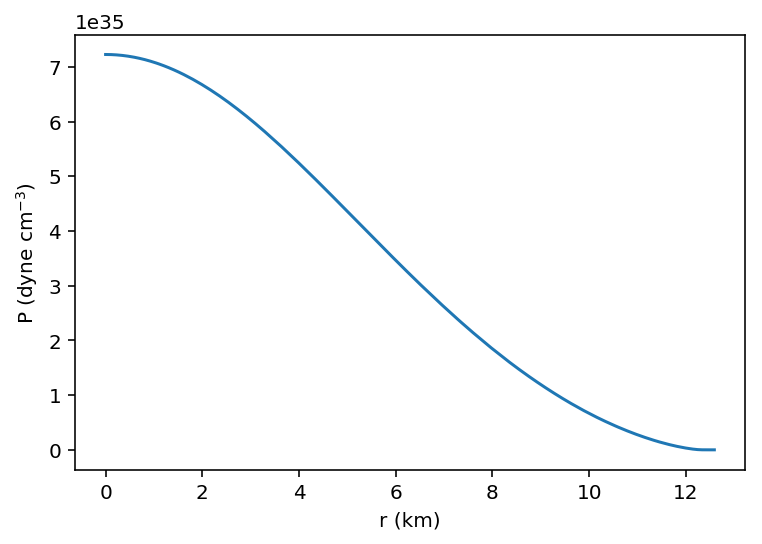

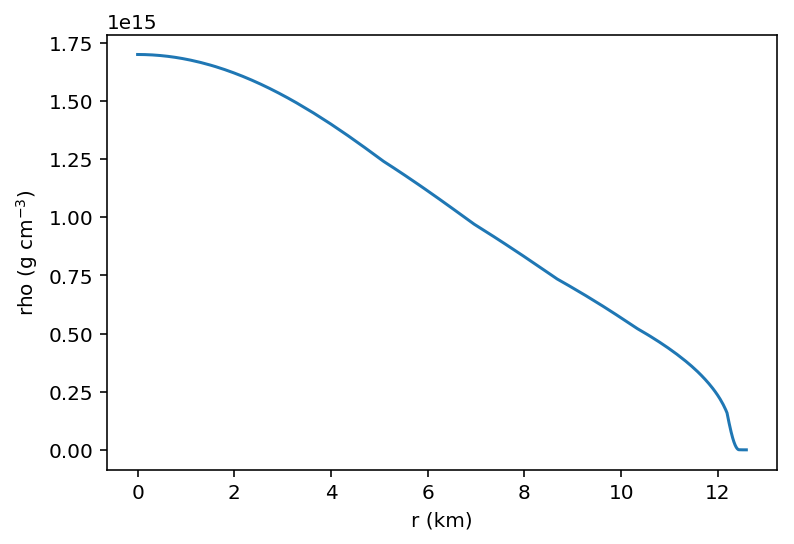

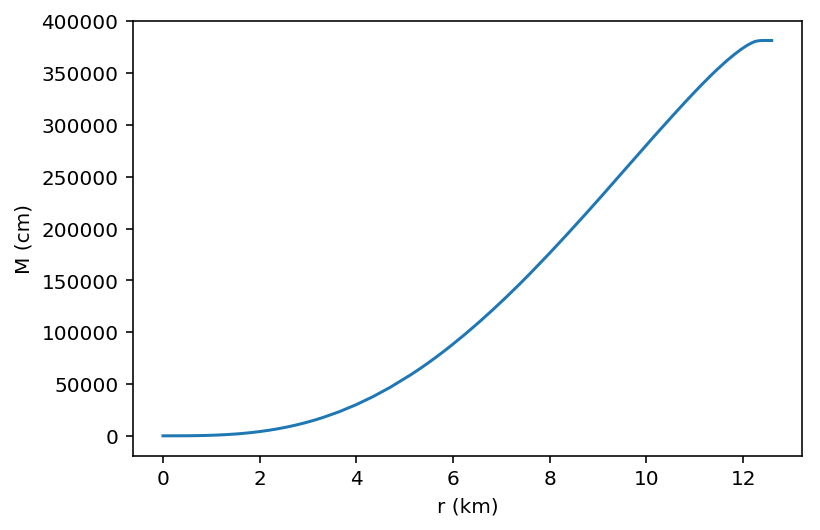

In [57]:
rho_c = 1.70e15
#rho_c = 0.76e15
#rho_c = 0.48e15
p_c = eos_integrate.lookup(
    eos_integrate.table_merged[:,1],
    eos_integrate.table_merged[:,2],
    rho_c)
print("rho_c:\t",rho_c)
print("p_c:\t",p_c)
N = eos_integrate.NeutronStar(a=0, b=0, rho_start=1e-6)
rs, xs = N.integrate(p_0 = p_c, phi_0 = 0)
rs = np.array(rs)
xs = np.array(xs)
M, nu, phi, psi, p, Mb, omega, omicron = xs.T
plt.figure()
plt.plot(rs/1e5, p)
plt.xlabel("r (km)")
plt.ylabel(r"P (dyne cm$^{-3}$)")

plt.figure()
rho = np.array([N.energy_density(pi) for pi in p])
plt.plot(rs/1e5, rho/3e10**2)
plt.xlabel("r (km)")
plt.ylabel(r"rho (g cm$^{-3}$)")

plt.figure()
plt.plot(rs/1e5, M)
plt.xlabel("r (km)")
plt.ylabel(r"M (cm)")

print("R:\t", N.R)
print("m_A:\t", N.m_A)
print("mb_A:\t", N.mb_A)
print("alpha_A:\t",N.alpha_A)
print("phi_0:\t",N.phi_0)

In [62]:
Rs = []
Ms = []
for rho_c in np.linspace(0.25e15,1.70e15,100):
    p_c = eos_integrate.lookup(
        eos_integrate.table_merged[:,1],
        eos_integrate.table_merged[:,2],
        rho_c)
    N = eos_integrate.NeutronStar(a=0, b=0, rho_start=1e-6)
    N.integrate(p_0 = p_c, phi_0 = 0)
    Rs.append(N.R)
    Ms.append(N.m_A)

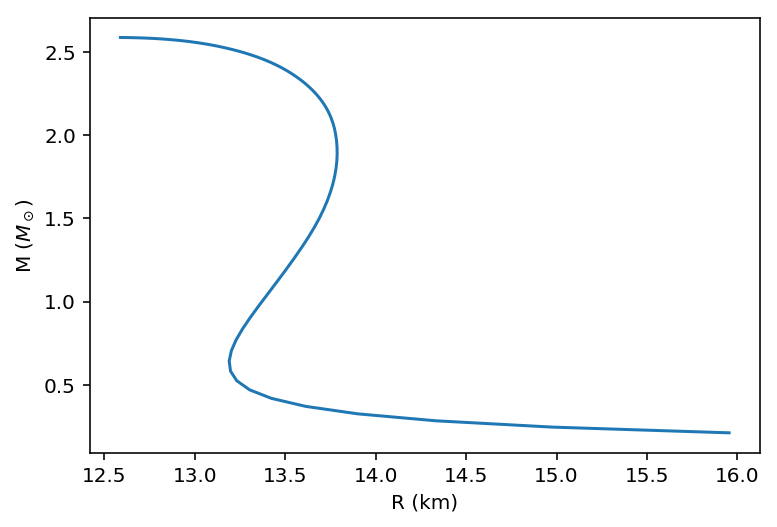

In [127]:
plt.plot(Rs,Ms)
plt.xlabel("R (km)")
plt.ylabel("M ($M_\odot$)")
plt.savefig("MR-GR.pdf")

rho_c:	 7.6e+14
p_c:	 1.50453980681e+35
R:	 13.7687276451
m_A:	 2.06384848722
mb_A:	 2.37116379906
alpha_A:	 -0.0141204532523
alpha_0:	 -0.00785490142959
beta_0:	 -3
phi_0:	 0.00261830047653
Delta:	 4.92152919691e-05


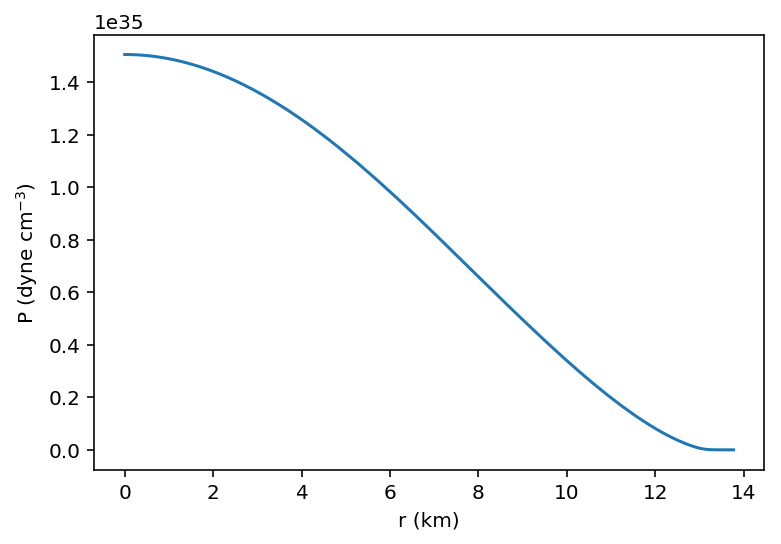

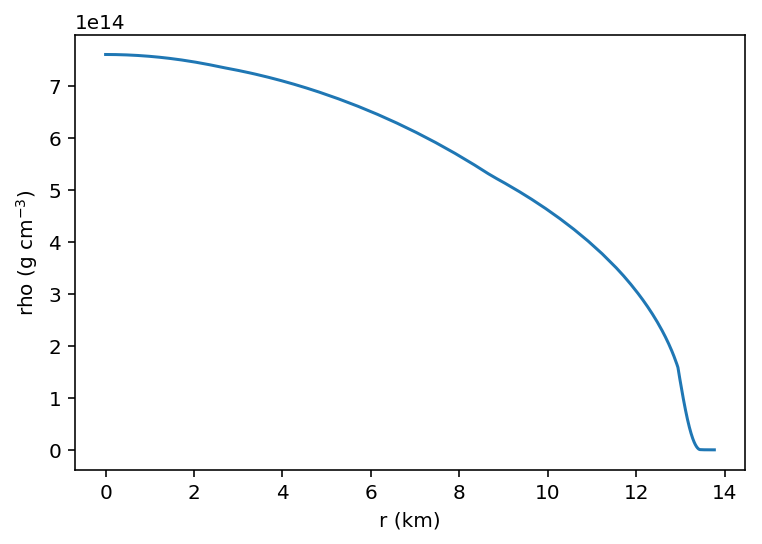

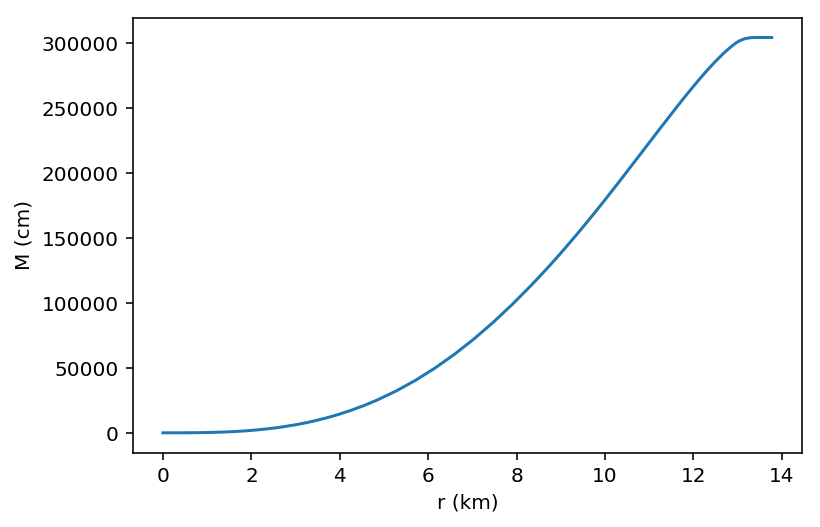

In [112]:
phi_c = 1e-2
#rho_c = 1.70e15
rho_c = 0.76e15
#rho_c = 0.48e15
p_c = eos_integrate.lookup(
    eos_integrate.table_merged[:,1],
    eos_integrate.table_merged[:,2],
    rho_c)
print("rho_c:\t",rho_c)
print("p_c:\t",p_c)
N = eos_integrate.NeutronStar(a=0, b=-3, rho_start=1e-6)
rs, xs = N.integrate(p_c = p_c, phi_c = phi_c)
rs = np.array(rs)
xs = np.array(xs)
M, nu, phi, psi, p, Mb, omega, omicron = xs.T
plt.figure()
plt.plot(rs/1e5, p)
plt.xlabel("r (km)")
plt.ylabel(r"P (dyne cm$^{-3}$)")

plt.figure()
rho = np.array([N.energy_density(pi) for pi in p])
plt.plot(rs/1e5, rho/3e10**2)
plt.xlabel("r (km)")
plt.ylabel(r"rho (g cm$^{-3}$)")

plt.figure()
plt.plot(rs/1e5, M)
plt.xlabel("r (km)")
plt.ylabel(r"M (cm)")

print("R:\t", N.R)
print("m_A:\t", N.m_A)
print("mb_A:\t", N.mb_A)
print("alpha_A:\t",N.alpha_A)
print("alpha_0:\t",N.alpha_0)
print("beta_0:\t",N.beta_0)
print("phi_0:\t",N.phi_0)
print("Delta:\t",N.Delta)

## Equation of state

The idea is to use the same EOS as in the 0348 paper; this is a very old equation of state but it's also stiff enough to allow 2.7 M_sun neutron stars, so it's a fairly conservative choice. Annoyingly, it's based on a tabulated EOS for high density, another for low density, and then supposedly on a third for intermediate density - but using the intermediate equation the way they claim to leads to discontinuities and non-monotonicity. I'm just going to ignore the intermediate bit.

In [34]:
baym_table_scan = """
     1.044E4      9.744E18  6.295E27  26     56    1.796
     2.622E4      4.968E19  1.581E28  26     56    1.744
     6.587E4      2.431E20  3.972E28  26     56    1.706
     1.654E5      1.151E21  9.976E28  26     56    1.670
     4.156E5      5.266E21  2.506E29  26     56    1.631
     1.044E6      2.318E22  6.294E29  26     56    1.586
     2.622E6      9.755E22  1.581E30  26     56    1.534
     6.588E6      3.911E23  3.972E30  26     56    1.482
     8.293E6      5.259E23  5.000E30  28     62    1.471
     1.655E7      1.435E24  9.976E30  28     62    1.437
     3.302E7      3.833E24  1.990E31  28     62    1.408
     6.589E7      1.006E25  3.972E31  28     62    1.386
     1.315E8      2.604E25  7.924E31  28     62    1.369
     2.624E8      6.676E25  1.581E32  28     62    1.357
     3.304E8      8.738E25  1.990E32  28     64    1.355
     5.237E8      1.629E26  3.155E32  28     64    1.350
     8.301E8      3.029E26  5.000E32  28     64    1.346
     1.045E9      4.129E26  6.294E32  28     64    1.344
     1.316E9      5.036E26  7.924E32  34     84    1.343
     1.657E9      6.860E26  9.976E32  34     84    1.342
     2.626E9      1.272E27  1.581E33  34     84    1.340
     4.164E9      2.356E27  2.506E33  34     84    1.338
     6.601E9      4.362E27  3.972E33  34     84    1.337
     8.312E9      5.662E27  5.000E33  32     82    1.336
     1.046E10     7.702E27  6.294E33  32     82    1.336
     1.318E10     1.048E28  7.924E33  32     82    1.336
     1.659E10     1.425E28  9.976E33  32     82    1.335
     2.090E10     1.938E28  1.256E34  32     82    1.335
     2.631E10     2.503E28  1.581E34  30     80    1.335
     3.313E10     3.404E28  1.990E34  30     80    1.335
     4.172E10     4.628E28  2.506E34  30     80    1.334
     5.254E10     5.949E28  3.155E34  28     78    1.334
     6.617E10     8.089E28  3.972E34  28     78    1.334
     8.332E10     1.100E29  5.000E34  28     78    1.334
     1.049E11     1.495E29  6.294E34  28     78    1.334
     1.322E11     2.033E29  7.924E34  28     78    1.334
     1.664E11     2.597E29  9.976E34  26     76    1.334
     1.844E11     2.892E29  1.105E35  42     124   1.334
     2.096E11     3.290E29  1.256E35  40     122   1.334
     2.640E11     4.473E29  1.581E35  40     122   1.334
     3.325E11     5.816E29  1.990E35  38     120   1.334
     4.188E11      7.538E29 2.506E35  36     118   1.334
     4.299E11      7.805E29 2.572E35  36     118   1.334
                    4.460E11       7.890E29 2.670E35   40     126   0.40

                     5.228E11       8.352E29 3.126E35   40     128   0.36

                     6.610E11       9.098E29 3.951E35   40     130   0.40

                     7.964E11       9.831E29 4.759E35   41     132   0.46

                     9.728E11       1.083E30 5.812E35   41     135   0.54

                     1.196E12       1.218E30 7.143E35   42     137   0.63

                     1.471E12       1.399E30 8.786E35   42     140   0.73

                     1.805E12       1.638E30 1.077E36   43     142   0.83

                     2.202E12       1.950E30 1.314E36   43     146   0.93

                     2.930E12       2.592E30 1.748E36   44     151   1.06

                     3.833E12       3.506E30 2.287E36   45     156   1.17

                     4.933E12       4.771E30 2.942E36   46     163   1.25

                     6.248E12       6.481E30 3.726E36   48     170   1.31

                     7.801E12       8.748E30 4.650E36   49     178   1.36

                     9.611E12       1.170E31 5.728E36   50     186   1.39

                     1.246E13       1.695E31 7.424E36   52     200   1.43

                     1.496E13       2.209E31 8.907E36   54     211   1.44

                     1.778E13       2.848E31 1.059E37   56     223   1.46

                     2.210E13       3.931E31 1.315E37   58     241   1.47

                     2.988E13       6.178E31 1.777E37   63     275   1.49

                     3.767E13       8.774E31 2.239E37   67     311   1.51

                     5.081E13       1.386E32 3.017E37   74     375   1.53

                     6.193E13       1.882E32 3.675E37   79     435   1.54

                     7.732E13       2.662E32 4.585E37   88     529   1.56

                     9.826E13       3.897E32 5.821E37   100    683   1.60

                     1.262E14       5.861E32 7.468E37   117    947   1.65

                     1.586E14       8.595E32 9.371E37   143   1390   1.70

                     2.004E14       1.286E33 1.182E38   201   2500   1.74

                     2.520E14       1.900E33 1.484E38                1.81

                     2.761E14       2.242E33 1.625E38                1.82

                     3.085E14       2.751E33 1.814E38                1.87

                     3.433E14       3.369E33 2.017E38                1.92

                     3.885E14       4.286E33 2.280E38                1.97

                     4.636E14       6.103E33 2.715E38                2.03

                     5.094E14       7.391E33 2.979E38                2.05
"""

In [35]:
t = []
for l in baym_table_scan.split("\n"):
    l = l.strip()
    if not l:
        continue
    rho, P, n = [float(v) for v in l.split()[:3]]
    n *= 1e-39  # convert to fm^{-3}
    t.append([n,rho,P])
    print("[%g, %g, %g]" % (n, rho, P))
t   

[6.295e-12, 10440, 9.744e+18]
[1.581e-11, 26220, 4.968e+19]
[3.972e-11, 65870, 2.431e+20]
[9.976e-11, 165400, 1.151e+21]
[2.506e-10, 415600, 5.266e+21]
[6.294e-10, 1.044e+06, 2.318e+22]
[1.581e-09, 2.622e+06, 9.755e+22]
[3.972e-09, 6.588e+06, 3.911e+23]
[5e-09, 8.293e+06, 5.259e+23]
[9.976e-09, 1.655e+07, 1.435e+24]
[1.99e-08, 3.302e+07, 3.833e+24]
[3.972e-08, 6.589e+07, 1.006e+25]
[7.924e-08, 1.315e+08, 2.604e+25]
[1.581e-07, 2.624e+08, 6.676e+25]
[1.99e-07, 3.304e+08, 8.738e+25]
[3.155e-07, 5.237e+08, 1.629e+26]
[5e-07, 8.301e+08, 3.029e+26]
[6.294e-07, 1.045e+09, 4.129e+26]
[7.924e-07, 1.316e+09, 5.036e+26]
[9.976e-07, 1.657e+09, 6.86e+26]
[1.581e-06, 2.626e+09, 1.272e+27]
[2.506e-06, 4.164e+09, 2.356e+27]
[3.972e-06, 6.601e+09, 4.362e+27]
[5e-06, 8.312e+09, 5.662e+27]
[6.294e-06, 1.046e+10, 7.702e+27]
[7.924e-06, 1.318e+10, 1.048e+28]
[9.976e-06, 1.659e+10, 1.425e+28]
[1.256e-05, 2.09e+10, 1.938e+28]
[1.581e-05, 2.631e+10, 2.503e+28]
[1.99e-05, 3.313e+10, 3.404e+28]
[2.506e-05, 4.1

[[6.294999999999999e-12, 10440.0, 9.744e+18],
 [1.5809999999999998e-11, 26220.0, 4.968e+19],
 [3.972e-11, 65870.0, 2.431e+20],
 [9.976e-11, 165400.0, 1.151e+21],
 [2.506e-10, 415600.0, 5.266e+21],
 [6.293999999999999e-10, 1044000.0, 2.318e+22],
 [1.5809999999999998e-09, 2622000.0, 9.755e+22],
 [3.972e-09, 6588000.0, 3.911e+23],
 [4.999999999999999e-09, 8293000.0, 5.259e+23],
 [9.976e-09, 16550000.0, 1.435e+24],
 [1.99e-08, 33020000.0, 3.833e+24],
 [3.972e-08, 65890000.0, 1.006e+25],
 [7.923999999999999e-08, 131500000.0, 2.604e+25],
 [1.581e-07, 262400000.0, 6.676e+25],
 [1.99e-07, 330400000.0, 8.738e+25],
 [3.155e-07, 523700000.0, 1.629e+26],
 [5e-07, 830100000.0, 3.029e+26],
 [6.294e-07, 1045000000.0, 4.129e+26],
 [7.924e-07, 1316000000.0, 5.036e+26],
 [9.976e-07, 1657000000.0, 6.86e+26],
 [1.581e-06, 2626000000.0, 1.272e+27],
 [2.506e-06, 4164000000.0, 2.356e+27],
 [3.972e-06, 6601000000.0, 4.362e+27],
 [4.9999999999999996e-06, 8312000000.0, 5.662e+27],
 [6.293999999999999e-06, 10460

In [36]:
malone_table = [
    [0.1, 16.8, 1.52, 1.74],
    [0.15, 22.8, 2.29, 4.55],
]
t = []
for l in malone_table:
    n, _, e, P = l
    e *= 1e35
    P *= 1e33
    rho = e/3e10**2
    t.append([n, rho, P])
    print("    [%g, %g, %g]," % (n, rho, P))
t

    [0.1, 1.68889e+14, 1.74e+33],
    [0.15, 2.54444e+14, 4.55e+33],


[[0.1, 168888888888888.9, 1.7399999999999998e+33],
 [0.15, 254444444444444.44, 4.55e+33]]

(1e+32, 3e+34)

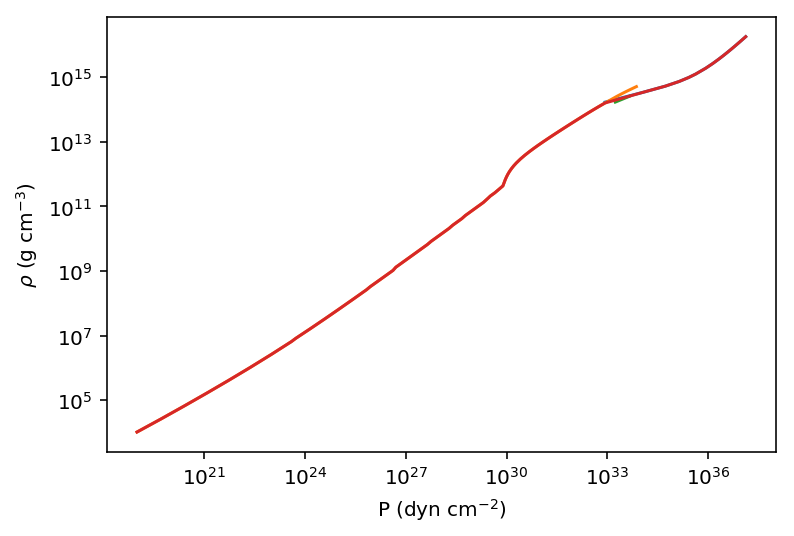

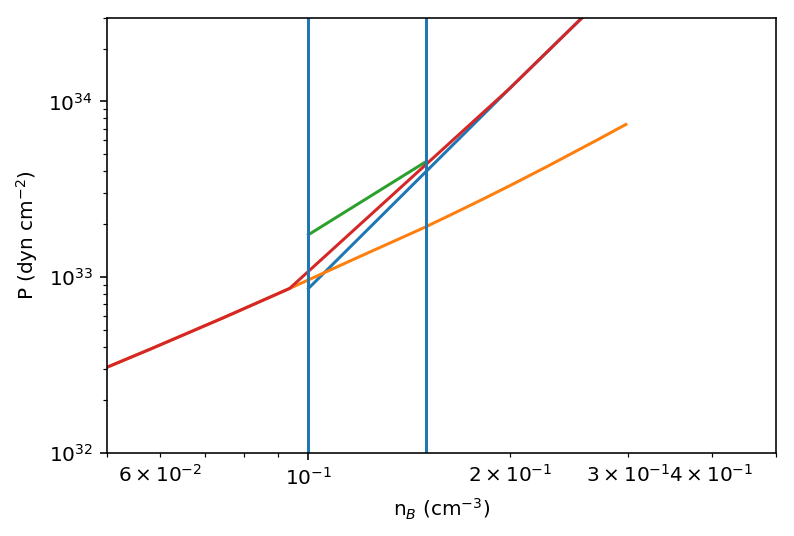

In [37]:

for t in [eos_integrate.table_20,
          eos_integrate.table_baym,
          eos_integrate.table_malone,
          eos_integrate.table_merged,
        ]:
    t = np.array(t)
    n, rho, P = t.T
    plt.figure(1)
    plt.loglog(P, rho)
    
    plt.figure(2)
    plt.loglog(n, P)
    
plt.figure(1)
plt.ylabel(r"$\rho$ (g cm$^{-3}$)")
plt.xlabel("P (dyn cm$^{-2}$)")

plt.figure(2)
plt.axvline(0.1)
plt.axvline(0.15)
plt.xlabel(r"n$_B$ (cm$^{-3}$)")
plt.ylabel("P (dyn cm$^{-2}$)")
plt.xlim(0.05,0.5)
plt.ylim(1e32,3e34)

(0, 1000000000000000.0)

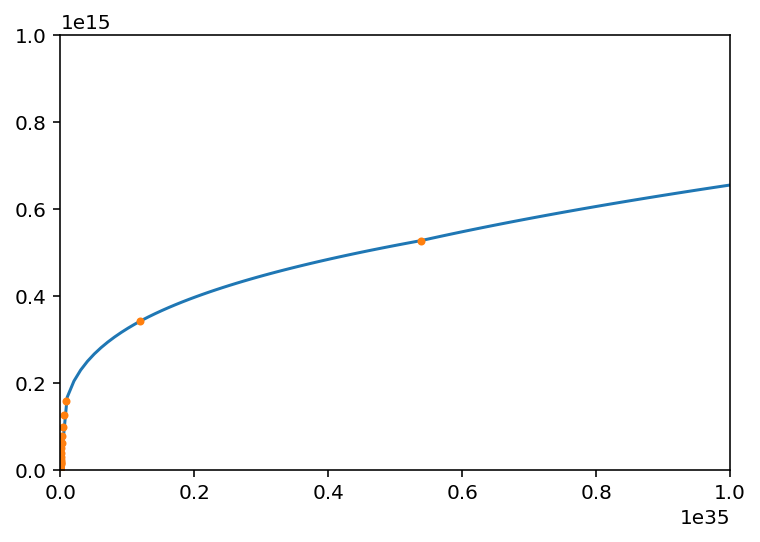

In [53]:
xs = np.linspace(0,1e35,100)
ys = [eos_integrate.eos_20_rho_p(x) for x in xs]
plt.plot(xs,ys)
plt.plot(eos_integrate.table_merged[:,2],
         eos_integrate.table_merged[:,1],
         ".")
plt.xlim(0,1e35)
plt.ylim(0,1e15)

## Exploring $\alpha$-$\beta$ space

We have a pulsar of known mass (${\sim}1.43 M_\odot$) and for each $\alpha_0$, $\beta_0$ we want to compute $\alpha_A$ and determine whether $\alpha_0(\alpha_A-\alpha_0)<\Delta_{max}$. But when we integrate an EOS we supply the central pressure, scalar value, and $\beta_0$, and we get out $\alpha_0$, $m_A$, and $\alpha_A$. So we have some root-finding to do. 
* Option 1: Use 2D root-finding to compute the right $\alpha_0$ for each $\beta_0$.
* Option 2: Build a database of pulsars on a grid of pressure, scalar value, and $\beta_0$. Then use interpolation to draw limit curves.
* Option 3: Use 1D root finding on the mass, then explore phi_0 values

Note that we have to do this for several different pulsar masses and constraint levels; at least 0348, 1738, and 0337. So Option 2 has some appeal. Particularly as we're not yet quite sure what our limit will be.

In [107]:
def f(x, beta_0):
    lp_c, lphi_c = x
    p_c = np.exp(lp_c)
    phi_c = np.exp(lphi_c)
    print(p_c, phi_c, beta_0)
    d = eos_integrate.evaluate(p_c, phi_c, beta_0)
    m_A = d["m_A"]
    alpha_0 = d["alpha_0"]
    alpha_A = d["alpha_A"]
    res = np.array([m_A-1.43, alpha_0*(alpha_A-alpha_0)-1.6e-6])
    print(res)
    return res

r = scipy.optimize.root(
    f, 
    [np.log(0.76e15), np.log(1e-3)],
    args=(-3,),
    method="lm")

7.6e+14 0.001 -3
[ -1.42930227e+00  -1.60000028e-06]
7.6e+14 0.001 -3
[ -1.42930227e+00  -1.60000028e-06]
7.6e+14 0.001 -3
[ -1.42930227e+00  -1.60000028e-06]
7.6000038804e+14 0.001 -3
[ -1.42930227e+00  -1.60000028e-06]
7.6e+14 0.00100000010293 -3
[ -1.42930227e+00  -1.60000028e-06]
inf 0.0 -3
[ nan  nan]
inf 0.0 -3
[ nan  nan]
4.47742327279e+74 0.0 -3
[ nan  nan]
1.37180624906e+21 0.0 -3
[ -1.29965404e+00  -1.60000000e-06]
1.37180724396e+21 0.0 -3
[ -1.29965401e+00  -1.60000000e-06]
1.37180624906e+21 0.0 -3
[ -1.29965404e+00  -1.60000000e-06]
1.72524033237e+21 0.0 -3


/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
eos_integrate.py:230: RuntimeWarning: invalid value encountered in double_scalars
  * a_phi*(e-3*p_c))
eos_integrate.py:203: RuntimeWarning: invalid value encountered in double_scalars
  * (a_phi*(e-3*p)+rho*psi*(e-p))
/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/scipy/integrate/_ode.py:869: UserWarning: vode: Illegal input detected. (See printed message.)
  'Unexpected istate=%s' % istate))
/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/scipy/integrate/_ode.py:869: UserWarning: vode: Repeated convergence failures. (Perhaps bad Jacobian supplied or wrong choice of MF or tolerances.)
  'Unexpected istate=%s' % istate))
eos_integrate.py:243: RuntimeWarning: invalid value encountered in double_scalars
  self.alpha_A = 2*phi/

[ -1.28990959e+00  -1.60000000e-06]
1.72524158948e+21 0.0 -3
[ -1.28990956e+00  -1.60000000e-06]
1.72524033237e+21 0.0 -3
[ -1.28990959e+00  -1.60000000e-06]
2.70984727378e+21 0.0 -3
[ -1.26905736e+00  -1.60000000e-06]
2.70984926657e+21 0.0 -3
[ -1.26905732e+00  -1.60000000e-06]
2.70984727378e+21 0.0 -3
[ -1.26905736e+00  -1.60000000e-06]
6.34411225377e+21 0.0 -3
[ -1.22263520e+00  -1.60000000e-06]
6.34411699958e+21 0.0 -3
[ -1.22263514e+00  -1.60000000e-06]
6.34411225377e+21 0.0 -3
[ -1.22263520e+00  -1.60000000e-06]
1.86472499194e+22 0.0 -3
[ -1.15010421e+00  -1.60000000e-06]
1.86472641683e+22 0.0 -3
[ -1.15010415e+00  -1.60000000e-06]
1.86472499194e+22 0.0 -3
[ -1.15010421e+00  -1.60000000e-06]
1.4832230834e+23 0.0 -3
[ -9.65739504e-01  -1.60000000e-06]
1.48322426261e+23 0.0 -3
[ -9.65739347e-01  -1.60000000e-06]
1.4832230834e+23 0.0 -3
[ -9.65739504e-01  -1.60000000e-06]
7.19237449692e+23 0.0 -3
[ -8.08276594e-01  -1.60000000e-06]
7.19238038429e+23 0.0 -3
[ -8.08276948e-01  -1.6000

In [114]:
def f(rho_c, phi_c, beta_0):
    p_c = eos_integrate.lookup(
        eos_integrate.table_merged[:,1],
        eos_integrate.table_merged[:,2],
        rho_c)

    # print(rho_c, p_c, phi_c, beta_0)
    d = eos_integrate.evaluate(p_c, phi_c, beta_0)
    m_A = d["m_A"]
    alpha_0 = d["alpha_0"]
    alpha_A = d["alpha_A"]
    # print(m_A, d["R"])
    res = m_A-1.43
    # print("alpha_0\t", alpha_0)
    # print("alpha_A\t", alpha_A)
    # print("R\t",res, alpha_0*(alpha_A-alpha_0))
    return res

r = scipy.optimize.brentq(
    f, 
    0.1e15,1.7e15,
    args=(1e-3,-3))

In [115]:
r

553380926715902.0

In [ ]:
solutions = set()

In [124]:
last = None
def f(rho_c, phi_c, beta_0):
    p_c = eos_integrate.lookup(
        eos_integrate.table_merged[:,1],
        eos_integrate.table_merged[:,2],
        rho_c)

    # print(rho_c, p_c, phi_c, beta_0)
    d = eos_integrate.evaluate(p_c, phi_c, beta_0)
    m_A = d["m_A"]
    alpha_0 = d["alpha_0"]
    alpha_A = d["alpha_A"]
    # print(m_A, d["R"])
    res = m_A-1.43
    # print("alpha_0\t", alpha_0)
    # print("alpha_A\t", alpha_A)
    # print("R\t",res, alpha_0*(alpha_A-alpha_0))
    return res

def g(phi_c, beta_0):
    rho_c = scipy.optimize.brentq(
        f, 
        0.1e15,1.7e15,
        args=(phi_c,beta_0))
    d = eos_integrate.evaluate(rho_c, phi_c, beta_0)
    global last
    last = (rho_c, phi_c, beta_0)
    print(last, d["Delta"])
    return np.abs(d["Delta"]) - 4e-7

xs = np.exp(np.linspace(np.log(1e-3),np.log(0.5),100))
ys = []
for phi_c in xs:
    ys.append(g(phi_c,-3))

#phi_c = scipy.optimize.brentq(
#    g, 
#    0.1e-3,0.5,
#    args=(-3,))

#d = eos_integrate.evaluate(*last)
#d

(553380926882925.6, 0.0010000000000000002, -3) -1.49283119058e-12
(553381016890000.9, 0.00106478597782335, -3) -1.69253215601e-12
(553381100546195.8, 0.0011337691785692262, -3) -1.91894866798e-12
(553381221689049.5, 0.0012072215234288095, -3) -2.17565501475e-12
(553381347852073.7, 0.0012854325502735374, -3) -2.46670364015e-12
(553381497802855.7, 0.0013687105549689707, -3) -2.79668931853e-12
(553381688203902.44, 0.0014573838066297739, -3) -3.17082161428e-12
(553381853537977.25, 0.0015518018416061992, -3) -3.59500756245e-12
(553382034596566.2, 0.0016523368413027301, -3) -4.07594466688e-12
(553382240303320.4, 0.0017593850992600724, -3) -4.62122625405e-12
(553382458606341.6, 0.0018733685832834674, -3) -5.23946310646e-12
(553382723823358.2, 0.0019947365987750282, -3) -5.9404176523e-12
(553383027887903.4, 0.0021239675598266911, -3) -6.73516011469e-12
(553383372472591.56, 0.0022615708750551352, -3) -7.63624236397e-12
(553383767164943.1, 0.0024080889556123909, -3) -8.65789727913e-12
(553384232

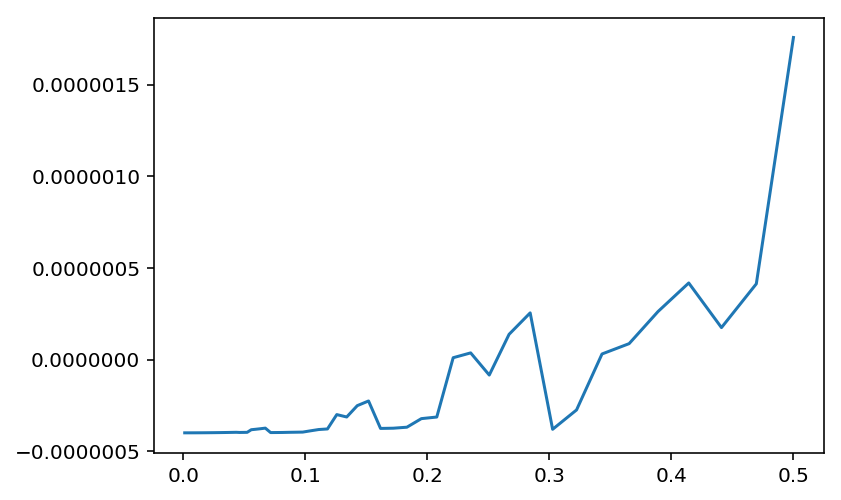

In [125]:
plt.plot(xs, ys)

In [128]:
l = []

In [129]:
l.insert?

In [170]:
points = []

In [171]:
eos_integrate.mr_curve(points, 0, 0, 1.43)

{'Delta': 0.0,
 'I_A': 2.2530921759394333e+36,
 'J_A': 2.2530921806348049e+36,
 'Omega': 1.0000000020839679,
 'Q1': 1.0,
 'Q2': 0.83131792872211197,
 'R': 13.652707150389318,
 'a': 0,
 'alpha_0': 0.0,
 'alpha_A': 0.0,
 'b': 0,
 'beta_0': 0,
 'initial': (6.204500705854884e+34, 0, 0),
 'm_A': 1.4299999999090507,
 'mb_A': 1.5663402707884728,
 'nu_hat': -0.369485943174853,
 'nu_prime': 3.2740070019246783e-07,
 'phi_0': 0.0,
 'rho_start': 1e-06}

In [172]:
len(points)

103

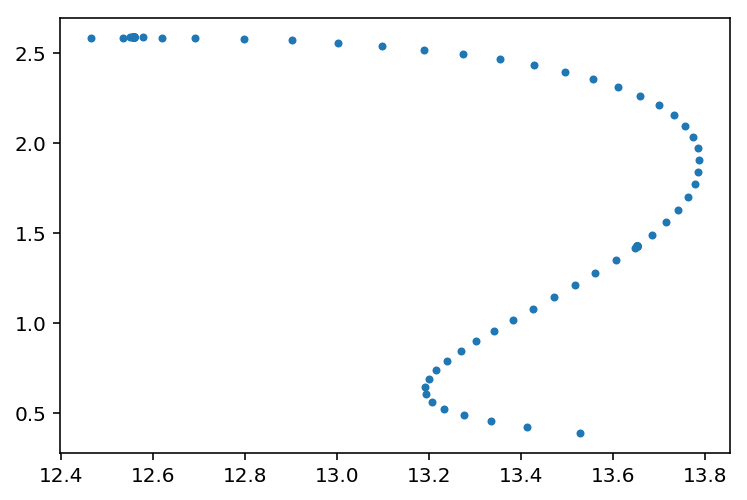

In [173]:
plt.plot([d["R"] for p_c,d in points],
         [d["m_A"] for p_c,d in points],
         ".")

In [177]:
eos_integrate.mr_curve(points, 0, 0, 2.0)

{'Delta': 0.0,
 'I_A': -4.846746127815239e+38,
 'J_A': -4.8467456783196633e+38,
 'Omega': 0.99999990725827925,
 'Q1': 1.0,
 'Q2': 0.75627353053489899,
 'R': 13.780042337385396,
 'a': 0,
 'alpha_0': 0.0,
 'alpha_A': 0.0,
 'b': 0,
 'beta_0': 0,
 'initial': (1.3668680456297637e+35, 0, 0),
 'm_A': 2.0000000001226454,
 'mb_A': 2.2859172117225328,
 'nu_hat': -0.55870431072849713,
 'nu_prime': 5.4310837607406777e-07,
 'phi_0': 0.0,
 'rho_start': 1e-06}

In [178]:
len(points)

114

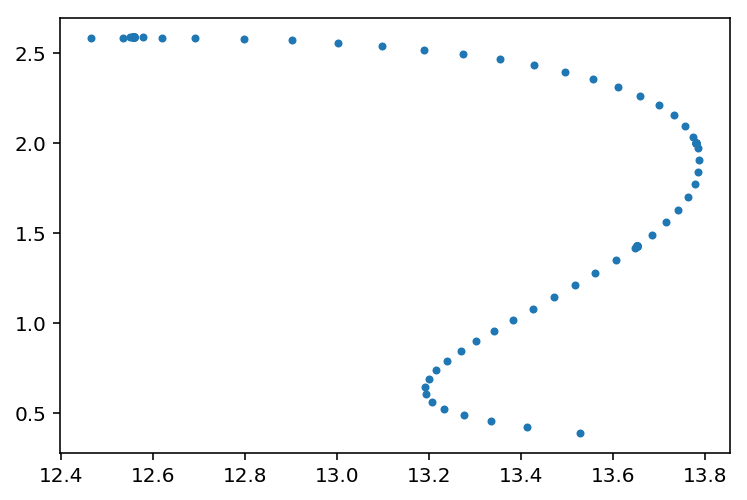

In [179]:
plt.plot([d["R"] for p_c,d in points],
         [d["m_A"] for p_c,d in points],
         ".")

In [183]:
alpha_map = {}

In [202]:
xs = np.exp(np.linspace(np.log(1e-3),np.log(0.5),10))
ys = []
for phi_c in xs:
    if phi_c not in alpha_map:
        alpha_map[phi_c] = []
    try:
        d = eos_integrate.mr_curve(alpha_map[phi_c], phi_c, -3, 1.43)
        ys.append(d)
        print(phi_c, d["Delta"])
    except FloatingPointError:
        pass

0.001 8.2435011682e-07
0.00199473659878 3.28004531139e-06
0.00397897409849 1.30508657302e-05
0.00793700525984 5.19233127008e-05
0.0158322348765 0.00020651349518
0.0315811383485 0.000820311314733
0.0629960524947 0.00324128964833
0.12566053149 0.0125039170587


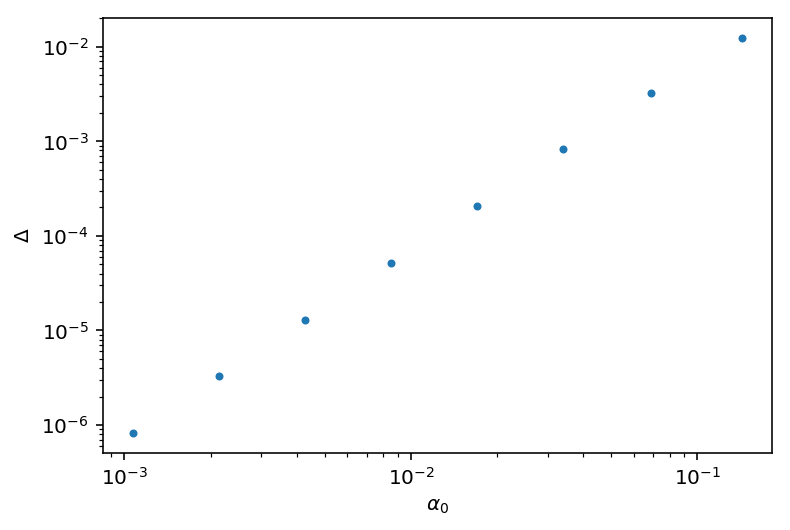

In [203]:
plt.loglog([abs(y["alpha_0"]) for y in ys], 
           [y["Delta"] for y in ys], ".")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\Delta$")

In [218]:
eos_integrate.explore_alpha(alpha_map, -3, 1.43, 
                            lambda d: abs(d["Delta"])-4e-7)

-3.92253382223e-15 -4e-07
Starting search
-3.92253382223e-15 -4e-07
2.14776929889e-15 -4e-07
0.0005 -1.93912083162e-07
0.000656820264279 -4.43642432244e-08
0.000696515524637 -7.93076999112e-11
0.00069658446682 -1.35522257923e-13
0.000696584520726 -6.00005822881e-14
0.000696584572769 -3.92253382223e-15
0.000696584574632 2.14776929889e-15
Brackting done 0.000696584572769 0.000696584574632
0.000696584572769 -3.92253382223e-15
0.000696584574632 2.14776929889e-15
0.000696584572769 -3.92253382223e-15
0.000696584574632 2.14776929889e-15


0.0006965845746315687

In [219]:
all_map = {}


In [650]:
betas = np.linspace(-6,6,40)
eos_integrate.explore_beta(all_map, betas, mass_0337, 
                           condition_0337)

Exploring for beta=-6.000000
0.0001 7.3791947018e-05
0.0001 7.3791947018e-05
0.0001 7.3791947018e-05
brentq with 0.0001 -7.3791947018e-05 1 inf
0.0001 7.3791947018e-05
0.0001000000005 7.37919469712e-05
0.50005 -1.72413708044
0.00012139661995 8.95809162483e-05
0.25008569831 -0.174793103157
0.000249436919042 0.000184064044819
0.125167567615 0.0466282919127
0.187626632962 -0.016240133328
0.171492245233 0.00835024690635
0.176971059303 0.000706122819012
0.177456074006 -4.50291759188e-06
0.177453000685 2.16114691143e-08
0.177453015364 2.16957535271e-10
0.177453015513 -7.69595220884e-11
0.177453015474 2.12569961633e-11
0.177453015483 -1.99636973619e-11
0.177453015479 -8.71661076651e-12
0.177453015476 5.8079374643e-12
0.177453015477 1.38122846494e-11
0.177453015478 -2.01014205281e-12
0.177453015478 condition: -1.59999891143e-06
0.177453015478 condition: -1.59999891143e-06
0.177456074006 condition: 8.38528197695e-07
0.177453015483 condition: -1.59998918887e-06
0.177453015513 condition: -1.59995

0.000332510856104 condition: -1.4731743793e-06
0.00307889861347 condition: 9.27433010321e-06
0.000708961788165 condition: -1.02344375517e-06
0.00148050293976 condition: 9.14302533907e-07
0.0011164604261 condition: -1.70171341073e-07
0.0011735845341 condition: -2.01119564565e-08
0.00118107589896 condition: 1.22375794138e-10
0.00118103059172 condition: -3.88098838929e-13
0.00118103559172 condition: 1.31599495957e-11
Exploring for beta=-3.538462
0.0001 -9.14850139783e-05
0 condition: -1.6e-06
0 condition: -1.6e-06
0.0001 condition: -1.58915784922e-06
0.0001 condition: -1.58915784922e-06
brentq with 0.0001 -1.58915784922e-06 1 inf
0.0001 condition: -1.58915784922e-06
0.000100005 condition: -1.58915676498e-06
0.5000500025 condition: 0.0360544686466
0.000122040102257 condition: -1.58385193196e-06
0.00670072147865 condition: 4.7083298586e-05
0.000336140519003 condition: -1.47749403763e-06
0.00321987077115 condition: 9.64080202807e-06
0.000719355197627 condition: -1.03894884512e-06
0.001538902

0.0001 -8.05488987328e-05
1 -0.945962595829
0 condition: -1.6e-06
1 condition: 0.0980861686184
0 condition: -1.6e-06
1 condition: 0.0980861686184
0.0001 condition: -1.59942576012e-06
0.0001 condition: -1.59942576012e-06
1 condition: 0.0980861686184
brentq with 0.0001 -1.59942576012e-06 1 0.0980861686184
0.0001 condition: -1.59942576012e-06
1.0 condition: 0.0980861686184
0.000116304436827 condition: -1.59922324167e-06
0.128865115031 condition: 0.000966276383909
0.000329036412629 condition: -1.59378299361e-06
0.0625486802827 condition: 0.00022385106476
0.000768898362266 condition: -1.56605065099e-06
0.0254354204058 condition: 3.55726783349e-05
0.00180902611996 condition: -1.41207510775e-06
0.0109836142371 condition: 5.32837065234e-06
0.00373103661676 condition: -8.00611545178e-07
0.00591886417837 condition: 4.11795290171e-07
0.00517576618576 condition: -6.16572374697e-08
0.0052725390758 condition: -3.592081876e-09
0.00527847396246 condition: 4.02333013901e-12
0.00527846732249 condition: 

0.001454234273 condition: -1.1000511176e-11
Exploring for beta=1.384615
0.0001 0.000188466228554
1 0.631705685272
0 condition: -1.6e-06
1 condition: 0.362945419527
0 condition: -1.6e-06
1 condition: 0.362945419527
0.0001 condition: -1.58480967236e-06
0.0001 condition: -1.58480967236e-06
1 condition: 0.362945419527
brentq with 0.0001 -1.58480967236e-06 1 0.362945419527
0.0001 condition: -1.58480967236e-06
1.0 condition: 0.362945419527
0.000104366067697 condition: -1.58345427569e-06
0.0052050414347 condition: 3.95566977705e-05
0.000300687321194 condition: -1.46265987198e-06
0.0025931117342 condition: 8.6144690994e-06
0.000633424672078 condition: -9.90522821741e-07
0.0012595041552 condition: 8.09726785627e-07
0.00097790246767 condition: -1.47356316894e-07
0.00102125898227 condition: -1.56910583773e-08
0.00102632772276 condition: 7.45739341619e-11
0.00102630374682 condition: -1.83931911712e-13
0.00102630874682 condition: 1.54064328777e-11
Exploring for beta=1.692308
0.0001 0.00024493634618

0.000100363679726 condition: -9.39741734401e-07
0.000171916810899 condition: 3.37302470835e-07
0.000153017662505 condition: -6.52280531024e-08
0.000156080174741 condition: -3.17908249455e-09
0.000156235617675 condition: 3.10459785453e-12
0.000156230617675 condition: -9.9303409509e-11
Exploring for beta=4.769231
0.0001 0.00116314987009
1 1.81590918201
0 condition: -1.6e-06
1 condition: 2.84300903776
0 condition: -1.6e-06
1 condition: 2.84300903776
0.0001 condition: -7.62308563277e-07
0.0001 condition: -7.62308563277e-07
1 condition: 2.84300903776
brentq with 0.0001 -7.62308563277e-07 1 2.84300903776
0.0001 condition: -7.62308563277e-07
1.0 condition: 2.84300903776
0.000100268107529 condition: -7.5781071415e-07
0.000145439632433 condition: 1.7194253043e-07
0.000137085903806 condition: -2.57645449076e-08
0.00013817453463 condition: -6.62536346567e-10
0.000138203157398 condition: 1.35706909518e-13
0.000138198157398 condition: -1.15633715753e-10
Exploring for beta=5.076923
0.0001 0.00129553

array([ -5.41545350e-01,  -4.39729663e-01,  -2.98755547e-01,
        -1.02249998e-02,  -4.21684130e-03,  -3.26284366e-03,
        -2.85499028e-03,  -2.64839729e-03,  -2.55103595e-03,
        -2.53165473e-03,  -2.58437981e-03,  -2.72344892e-03,
        -2.99631815e-03,  -3.54736156e-03,  -5.05541578e-03,
        -1.02128095e-02,  -3.87546264e-03,  -2.75397014e-03,
        -2.20686850e-03,  -1.86678951e-03,   1.62918992e-03,
         1.45162979e-03,   1.31261643e-03,   1.20019761e-03,
         1.10703653e-03,   1.02834759e-03,   9.60854800e-04,
         9.02230136e-04,   8.50764986e-04,   8.05185708e-04,
         7.64494004e-04,   7.27929880e-04,   6.94857034e-04,
         6.64810273e-04,   6.37356111e-04,   6.12181467e-04,
         5.89013510e-04,   5.67586095e-04,   5.47734026e-04,
         5.29269231e-04])

In [673]:
betas = sorted(all_map.keys())
ds = [eos_integrate.explore_alpha(all_map[beta], beta, mass_0337,
                                      condition_0337)
          for beta in betas]
alphas = np.array([d["alpha_0"] for d in ds])


0.0001 7.3791947018e-05
0.0001 7.3791947018e-05
0.177453015476 5.8079374643e-12
0.182359581327 -0.00751454650386
0.177455017226 -2.95368690914e-06
0.177453015479 -8.71661076651e-12
0.177453015477 1.38122846494e-11
0.177453015478 -2.01014205281e-12
0.177453015477 1.38122846494e-11
0.177453015478 -2.01014205281e-12
brentq with 0.177453015477 -1.38122846494e-11 0.177453015478 2.01014205281e-12
0.177453015477 1.38122846494e-11
0.177453015478 -2.01014205281e-12
0.177453015478 condition: -1.59999891143e-06
0.177453015478 condition: -1.59999891143e-06
0.182359581328 condition: 0.0041228703216
0.177456074006 condition: 8.38528197695e-07
0.177453015513 condition: -1.59995832339e-06
0.177455017226 condition: -4.53313960034e-10
0.177455022275 condition: 4.01584514901e-09
0.177455017226 condition: -4.53313960034e-10
0.177455022275 condition: 4.01584514901e-09
brentq with 0.177455017226 -4.53313960034e-10 0.177455022275 4.01584514901e-09
0.177455017226 condition: -4.53313960034e-10
0.177455022275 c

0.00234485762723 condition: 2.90314360033e-06
0.00139771141635 condition: 2.21261282726e-12
0.00139770641635 condition: -9.23472930705e-12
0.00139771141635 condition: 2.21261282726e-12
brentq with 0.00139770641635 -9.23472930705e-12 0.00139771141635 2.21261282726e-12
0.00139770641635 condition: -9.23472930705e-12
0.00139771141635 condition: 2.21261282726e-12
0.0001 -0.000108208965014
1 -2.65184807052
0 condition: -1.6e-06
1 condition: 0.965016793446
0 condition: -1.6e-06
1 condition: 0.965016793446
0.00143818350381 condition: -9.60623006504e-11
0.00147789317134 condition: 8.94731053678e-08
0.00143822168073 condition: -1.11220525835e-11
0.00143822668073 condition: 2.69184042495e-15
0.00143822168073 condition: -1.11220525835e-11
0.00143822668073 condition: 2.69184042495e-15
brentq with 0.00143822168073 -1.11220525835e-11 0.00143822668073 2.69184042495e-15
0.00143822168073 condition: -1.11220525835e-11
0.00143822668073 condition: 2.69184042495e-15
0.0001 -0.000112098200723
1 -2.3484701134

0.00424116573669 condition: -5.76537817805e-10
0.00750091945429 condition: 3.40301719209e-06
0.00424193019284 condition: 9.69305217332e-14
0.00424192519284 condition: -3.67482897377e-12
0.00424192519284 condition: -3.67482897377e-12
0.00424193019284 condition: 9.69305217332e-14
brentq with 0.00424192519284 -3.67482897377e-12 0.00424193019284 9.69305217332e-14
0.00424192519284 condition: -3.67482897377e-12
0.00424193019284 condition: 9.69305217332e-14
0.0001 6.97924631568e-05
1 0.640796605212
0 condition: -1.6e-06
1 condition: 0.321652662898
0 condition: -1.6e-06
1 condition: 0.321652662898
0.0144956994646 condition: 3.44057803124e-05
0.00305597010143 condition: 1.76850062025e-12
0.00170607220105 condition: -1.10132823694e-06
0.00305505207466 condition: -9.59389817843e-10
0.00305596510143 condition: -3.46750809163e-12
0.00305596510143 condition: -3.46750809163e-12
0.00305597010143 condition: 1.76850062025e-12
brentq with 0.00305596510143 -3.46750809163e-12 0.00305597010143 1.76850062025

0.000173672770992 condition: -8.36250315818e-11
0.000173677770992 condition: 8.49876937963e-12
0.0001 0.00103888999029
1 1.73866241745
0 condition: -1.6e-06
1 condition: 2.59685446302
0 condition: -1.6e-06
1 condition: 2.59685446302
0.000156080174741 condition: -3.17908249455e-09
0.000156235617675 condition: 3.10459785453e-12
0.000156230617675 condition: -9.9303409509e-11
0.000156230617675 condition: -9.9303409509e-11
0.000156235617675 condition: 3.10459785453e-12
brentq with 0.000156230617675 -9.9303409509e-11 0.000156235617675 3.10459785453e-12
0.000156230617675 condition: -9.9303409509e-11
0.000156235617675 condition: 3.10459785453e-12
0.0001 0.00116314987009
1 1.81590918201
0 condition: -1.6e-06
1 condition: 2.84300903776
0 condition: -1.6e-06
1 condition: 2.84300903776
0.00013817453463 condition: -6.62536346567e-10
0.000138203157398 condition: 1.35706909518e-13
0.000138198157398 condition: -1.15633715753e-10
0.000138198157398 condition: -1.15633715753e-10
0.000138203157398 conditi

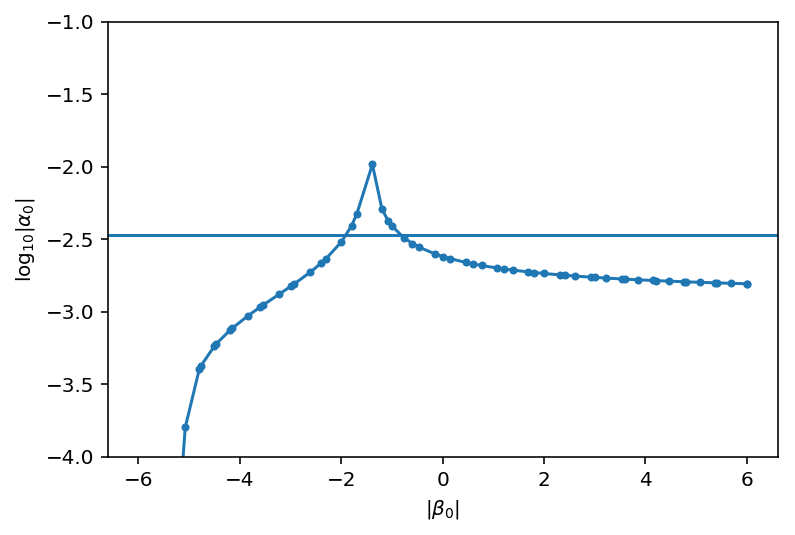

In [676]:
plt.plot(betas, np.log10(np.abs(alphas)), ".-")
plt.xlabel(r"$|\beta_0|$")
plt.ylabel(r"$\log_{10}|\alpha_0|$")
plt.ylim(-4,-1)
cassini_limit = 3.4e-3
plt.axhline(np.log10(cassini_limit))

plt.savefig("alpha-beta-0337-ska.pdf")

## Checking the calculation of $\alpha_0$

In [272]:
mass = 1.43
phi_c = 0.001
beta = -1
points = []

d = eos_integrate.mr_curve(points, phi_c, beta, mass) 

In [273]:
d["alpha_0"], d["phi_0"], d["alpha_A"]

(-0.00076589550443647647, 0.00076589550443647647, -0.00068632362755137867)

In [274]:
N = eos_integrate.NeutronStar(a = d["alpha_0"], b = d["beta_0"])
N.integrate(d["initial"][0], d["initial"][1]-d["phi_0"])
N.alpha_0, N.phi_0, N.alpha_A

(-0.00076589553916621802, 3.4729741516447907e-11, -0.00068632371175226137)

In [275]:
N.Delta

-6.0943707659653578e-08

## Multiple constraints

In [785]:
nscn = "ns_cache.pickle"
if os.path.exists(nscn):
    ns_cache = pickle.load(open(nscn,"rb"))
    print(len(ns_cache))
all_map_new = {}
for (p_c, phi_c, beta_0), d in ns_cache.items():
    if beta_0 not in all_map_new:
        all_map_new[beta_0] = {}
    alpha_map = all_map_new[beta_0]
    if phi_c not in alpha_map:
        alpha_map[phi_c] = []
    mr_curve = alpha_map[phi_c]
    mr_curve.append((p_c, d))
    mr_curve.sort()
all_map = all_map_new

435072


In [739]:
betas = np.linspace(-6, 6.01, 81) # can't have beta=0


In [740]:
llr_betas = betas
llr_delta = 1e-3
# FIXME: 1738 paper shows this as an upper limit with a funny shape
# how to get alpha_A for Earth Moon and Sun?

In [741]:
cassini_limit = 3.4e-3
alphas_cassini = cassini_limit*np.ones_like(betas)

In [804]:
def condition_0348(d):
    return (np.abs(d["alpha_A"] - d["alpha_0"]) - 0.005)
mass_0348 = 2.0
alphas_0348 = eos_integrate.explore_beta(all_map,
                                         betas,
                                         mass_0348,
                                         condition_0348)

Exploring for beta=-6.000000
1e-06 1.5408761239e-06
1e-06 1.5408761239e-06
0.177453015476 0.13798278268
0.182359580757 0.133929178106
0.25008569831 0.0100656583167
0.253601483935 -2.186584247e-13
0.253601216775 7.79137713014e-07
0.253601483934 1.51861856423e-12
0.253601483934 1.51861856423e-12
0.253601483935 -2.186584247e-13
brentq with 0.253601483934 -1.51861856423e-12 0.253601483935 2.186584247e-13 xtol 1e-12
0.253601483934 1.51861856423e-12
0.253601483935 -2.186584247e-13
phi_c_0 0.253601483935
0.253601483935 0 condition: 0.642814993224
No solution
Exploring for beta=-5.849875
1e-06 1.37568480472e-06
1e-06 1.37568480472e-06
0.164806876517 0.124473698105
0.170271083439 0.12141951536
0.246701756797 1.66544017022e-10
0.246701756824 -8.71322755648e-11
0.246701756804 -2.17418206185e-08
0.246701756798 -2.17859409948e-08
0.246701756797 1.66544017022e-10
0.246701756798 -2.17859409948e-08
brentq with 0.246701756797 -1.66544017022e-10 0.246701756798 2.17859409948e-08 xtol 1e-12
0.246701756797

returning 0.00487838594988 -0.00293448730681 -6.36304377244e-13
Exploring for beta=-3.297750
1e-06 -6.73460474673e-07
No spontaneous scalarization found
0 0 condition: -0.005
0 0 condition: -0.005
0.005572167448 0.005572167448 condition: -3.00160677563e-12
0.0704475912067 0.0704475912067 condition: 0.0568564763192
0.00557219512124 0.00557219512124 condition: 2.48226304745e-08
0.00557216744944 0.00557216744944 condition: 3.56557405129e-12
0.00557216744866 0.00557216744866 condition: 9.78566186416e-13
0.005572167448 0.005572167448 condition: -3.00160677563e-12
0.00557216744866 0.00557216744866 condition: 9.78566186416e-13
brentq with 0.005572167448 -3.00160677563e-12 0.00557216744866 9.78566186416e-13 xtol 1e-12
0.005572167448 0.005572167448 condition: -3.00160677563e-12
0.00557216744866 0.00557216744866 condition: 9.78566186416e-13
returning 0.00557216744866 -0.00375351518478 9.78566186416e-13
Exploring for beta=-3.147625
1e-06 -7.38231386483e-07
No spontaneous scalarization found
0 0 c

0.174219011212 0.174219011212 condition: 0.00150598515
0.173282793283 0.173282793283 condition: 0.00148829854987
0.119729359995 0.119729359995 condition: 1.29617584027e-12
0.119729359986 0.119729359986 condition: 1.11053267277e-12
0.119729359985 0.119729359985 condition: 8.0777485395e-13
0.119729359984 0.119729359984 condition: -6.94454042882e-13
0.119729359985 0.119729359985 condition: 8.0777485395e-13
brentq with 0.119729359984 -6.94454042882e-13 0.119729359985 8.0777485395e-13 xtol 1e-12
0.119729359984 0.119729359984 condition: -6.94454042882e-13
0.119729359985 0.119729359985 condition: 8.0777485395e-13
returning 0.119729359984 -0.117399359872 -6.94454042882e-13
Exploring for beta=-1.796500
1e-06 -9.55369722927e-07
1 -1.52572814136
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.217491187311
0 0 condition: -0.005
1 1 condition: 0.217491187311
0.244304514302 0.244304514302 condition: -1.40526502761e-10
0.24771154368 0.24771154368 condition: 0.000157810214176

0.0493810626803 0.0493810626803 condition: -0.00229536619009
1 1 condition: 0.0405281842707
0.0913991851973 0.0913991851973 condition: -1.74970281319e-13
0.0913991852136 0.0913991852136 condition: 7.56034124194e-13
0.0913991851983 0.0913991851983 condition: -6.89175279345e-13
0.0913991851992 0.0913991851992 condition: 2.42084911145e-12
0.0913991851983 0.0913991851983 condition: -6.89175279345e-13
0.0913991851992 0.0913991851992 condition: 2.42084911145e-12
brentq with 0.0913991851983 -6.89175279345e-13 0.0913991851992 2.42084911145e-12 xtol 1e-12
0.0913991851983 0.0913991851983 condition: -6.89175279345e-13
0.0913991851992 0.0913991851992 condition: 2.42084911145e-12
returning 0.0913991851983 -0.0127191155102 -6.89175279345e-13
Exploring for beta=0.005000
1e-06 5.00713564859e-09
1 0.00500714115924
No spontaneous scalarization found
0 0 condition: -0.005
0 0 condition: -0.005
1.26294345849 1.26294345849 condition: -0.00235154585096
2.32097370795 2.32097370795 condition: -3.07022636481e-

0.0320896140764 0.0320896140764 condition: 0.0478542653475
0.00304199808055 0.00304199808055 condition: 8.21472746163e-09
0.00304199308291 0.00304199308291 condition: 4.42068257001e-14
0.00304199308241 0.00304199308241 condition: -8.10566024023e-13
0.00304199308291 0.00304199308291 condition: 4.42068257001e-14
brentq with 0.00304199308241 -8.10566024023e-13 0.00304199308291 4.42068257001e-14 xtol 1e-12
0.00304199308241 0.00304199308241 condition: -8.10566024023e-13
0.00304199308291 0.00304199308291 condition: 4.42068257001e-14
returning 0.00304199308291 0.00859382707033 4.42068257001e-14
Exploring for beta=1.956625
1e-06 3.16037886135e-06
No spontaneous scalarization found
0 0 condition: -0.005
0 0 condition: -0.005
0.0284279363141 0.0284279363141 condition: 0.0482320850645
0.000781695008946 0.000781695008946 condition: -0.00353877425593
0.00267454495467 0.00267454495467 condition: -3.9188778595e-07
0.00267475458895 0.00267475458895 condition: 7.90600224176e-15
0.00267475457266 0.00267

1 1 condition: 0.456430556755
0.000854344397182 0.000854344397182 condition: -8.17146850616e-07
0.0120625028036 0.0120625028036 condition: 0.0655979405903
0.000854484044752 0.000854484044752 condition: 1.0425792174e-12
0.000854484043016 0.000854484043016 condition: -1.01588555276e-11
0.000854484044252 0.000854484044252 condition: -2.62683191171e-12
0.000854484044252 0.000854484044252 condition: -2.62683191171e-12
0.000854484044752 0.000854484044752 condition: 1.0425792174e-12
brentq with 0.000854484044252 -2.62683191171e-12 0.000854484044752 1.0425792174e-12 xtol 1e-12
0.000854484044252 0.000854484044252 condition: -2.62683191171e-12
0.000854484044752 0.000854484044752 condition: 1.0425792174e-12
returning 0.000854484044752 0.00735417528746 1.0425792174e-12
Exploring for beta=3.908250
1e-06 9.18999352999e-06
1 0.5321651511
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.477508771095
0 0 condition: -0.005
1 1 condition: 0.477508771095
0.000793656113802 0.000793

0.000396418643433 0.000396418643433 condition: -1.31106757395e-12
0.000396418644176 0.000396418644176 condition: 9.38025872255e-12
returning 0.000396418643433 0.00679003648264 -1.31106757395e-12
Exploring for beta=5.709750
1e-06 1.79992844983e-05
1 0.619474348211
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.555445194635
0 0 condition: -0.005
1 1 condition: 0.555445194635
0.000171053310612 0.000171053310612 condition: -0.00272112440119
0.00557291968084 0.00557291968084 condition: 0.0692317449448
0.000375483397493 0.000375483397493 condition: 2.41338297265e-06
0.000375302247382 0.000375302247382 condition: -4.82648122857e-12
0.000375302247882 0.000375302247882 condition: 1.50508858848e-12
0.000375302247382 0.000375302247382 condition: -4.82648122857e-12
0.000375302247882 0.000375302247882 condition: 1.50508858848e-12
brentq with 0.000375302247382 -4.82648122857e-12 0.000375302247882 1.50508858848e-12 xtol 1e-12
0.000375302247382 0.000375302247382 condition: -

In [748]:
pbdot_1738 = 4e-12
def condition_1738(d):
    return (np.abs(d["alpha_A"] - d["alpha_0"]) - 0.0018)
mass_1738 = 1.46
#lim_1738 = pbdot_1738*c**3/

alphas_1738 = eos_integrate.explore_beta(all_map,
                                         betas,
                                         mass_1738,
                                         condition_1738)

Exploring for beta=-6.000000
1e-06 7.83235993621e-07
1e-06 7.83235993621e-07
0.177453015476 0.00735528358929
0.182359580757 8.64907395703e-10
0.25008569831 -0.165458006754
0.182359581328 -6.24400531279e-12
0.182359581326 4.11362610642e-12
0.182359581327 1.60588209397e-12
0.182359581327 1.60588209397e-12
0.182359581328 -6.24400531279e-12
brentq with 0.182359581327 -1.60588209397e-12 0.182359581328 6.24400531279e-12 xtol 1e-12
0.182359581327 1.60588209397e-12
0.182359581328 -6.24400531279e-12
phi_c_0 0.182359581327
0.182359581327 0 condition: 0.550037893301
No solution
Exploring for beta=-5.849875
1e-06 6.43612969358e-07
1e-06 6.43612969358e-07
0.164806876517 0.00669046010901
0.170271083439 -2.01595225635e-09
0.170271080985 6.48745440151e-10
0.170271081929 -3.83185289055e-12
0.170271081918 1.03031550579e-09
0.170271081928 1.97914389963e-11
0.170271081928 1.97914389963e-11
0.170271081929 -3.83185289055e-12
brentq with 0.170271081928 -1.97914389963e-11 0.170271081929 3.83185289055e-12 xtol

0.00314187015361 0.00314187015361 condition: 0.00336965163816
0.00114384077867 0.00114384077867 condition: 8.21787871931e-05
0.00109389821456 0.00109389821456 condition: -8.86902964264e-13
0.00109389821584 0.00109389821584 condition: 1.28996639759e-12
0.00109389821506 0.00109389821506 condition: 8.79136173582e-15
0.00109389821456 0.00109389821456 condition: -8.86902964264e-13
0.00109389821506 0.00109389821506 condition: 8.79136173582e-15
brentq with 0.00109389821456 -8.86902964264e-13 0.00109389821506 8.79136173582e-15 xtol 1e-12
0.00109389821456 0.00109389821456 condition: -8.86902964264e-13
0.00109389821506 0.00109389821506 condition: 8.79136173582e-15
returning 0.00109389821506 -0.000730121408913 8.79136173582e-15
Exploring for beta=-3.898250
1e-06 -7.41695407155e-07
No spontaneous scalarization found
0 0 condition: -0.0018
0 0 condition: -0.0018
0.00346793137047 0.00346793137047 condition: 0.00341927739991
0.00118018715258 0.00118018715258 condition: -2.3692773196e-05
0.00119592901

0.514497577173 0.514497577173 condition: 0.00223360575912
0.00380163916489 0.00380163916489 condition: 2.19682458422e-10
0.0017315329063 0.0017315329063 condition: -0.000980103738912
0.00229556029348 0.00229556029348 condition: -0.000713044980523
0.00380163869996 0.00380163869996 condition: 4.83663890188e-13
0.00380163869946 0.00380163869946 condition: -9.59228356467e-14
0.00380163869946 0.00380163869946 condition: -9.59228356467e-14
0.00380163869996 0.00380163869996 condition: 4.83663890188e-13
brentq with 0.00380163869946 -9.59228356467e-14 0.00380163869996 4.83663890188e-13 xtol 1e-12
0.00380163869946 0.00380163869946 condition: -9.59228356467e-14
0.00380163869996 0.00380163869996 condition: 4.83663890188e-13
returning 0.00380163869946 -0.00423388694368 -9.59228356467e-14
Exploring for beta=-2.397000
1e-06 -1.11885142417e-06
1 -2.13464516463
No spontaneous scalarization found
0 0 condition: -0.0018
1 1 condition: 0.280633184215
0 0 condition: -0.0018
1 1 condition: 0.280633184215
0.

0.0285718175017 0.0285718175017 condition: 0.00100599434222
0.00521497115047 0.00521497115047 condition: -0.00128769547838
0.0183252114207 0.0183252114207 condition: 1.02615810814e-11
0.0183252113146 0.0183252113146 condition: -8.53850410515e-13
0.0183252113157 0.0183252113157 condition: 1.29826271261e-13
0.0183252113151 0.0183252113151 condition: -3.02575022329e-12
0.0183252113151 0.0183252113151 condition: -3.02575022329e-12
0.0183252113157 0.0183252113157 condition: 1.29826271261e-13
brentq with 0.0183252113151 -3.02575022329e-12 0.0183252113157 1.29826271261e-13 xtol 1e-12
0.0183252113151 0.0183252113151 condition: -3.02575022329e-12
0.0183252113157 0.0183252113157 condition: 1.29826271261e-13
returning 0.0183252113157 -0.0112226798101 1.29826271261e-13
Exploring for beta=-0.595500
1e-06 -5.09946585928e-07
1 -0.538179021012
No spontaneous scalarization found
0 0 condition: -0.0018
1 1 condition: 0.0705883646655
0 0 condition: -0.0018
1 1 condition: 0.0705883646655
0.0278674331462 0

0.00231577093335 0.00231577093335 condition: -0.00102148802651
0.00535393871027 0.00535393871027 condition: -8.00103362561e-08
0.00535417669211 0.00535417669211 condition: -1.97503905591e-13
0.00535417669272 0.00535417669272 condition: 6.45590785692e-13
0.00535417669211 0.00535417669211 condition: -1.97503905591e-13
0.00535417669272 0.00535417669272 condition: 6.45590785692e-13
brentq with 0.00535417669211 -1.97503905591e-13 0.00535417669272 6.45590785692e-13 xtol 1e-12
0.00535417669211 0.00535417669211 condition: -1.97503905591e-13
0.00535417669272 0.00535417669272 condition: 6.45590785692e-13
returning 0.00535417669211 0.00482893046975 -1.97503905591e-13
Exploring for beta=0.905750
1e-06 1.11731713986e-06
1 0.468510343484
No spontaneous scalarization found
0 0 condition: -0.0018
1 1 condition: 0.436927741437
0 0 condition: -0.0018
1 1 condition: 0.436927741437
0.00848262200043 0.00848262200043 condition: 0.00187898150579
0.0018591995993 0.0018591995993 condition: -0.000993717779207
0

0.000495005234575 0.000495005234575 condition: -0.000899321426485
0.00061884582434 0.00061884582434 condition: -0.000673988815132
0.000989250745985 0.000989250745985 condition: -2.07784794672e-08
0.000989262164827 0.000989262164827 condition: -4.99230864981e-13
0.000989262164827 0.000989262164827 condition: -4.99230864981e-13
0.000989262165515 0.000989262165515 condition: 1.25255405006e-12
brentq with 0.000989262164827 -4.99230864981e-13 0.000989262165515 1.25255405006e-12 xtol 1e-12
0.000989262164827 0.000989262164827 condition: -4.99230864981e-13
0.000989262165515 0.000989262165515 condition: 1.25255405006e-12
returning 0.000989262164827 0.00361150153717 -4.99230864981e-13
Exploring for beta=2.407000
1e-06 4.00284652554e-06
1 0.949962842826
No spontaneous scalarization found
0 0 condition: -0.0018
1 1 condition: 0.816223933144
0 0 condition: -0.0018
1 1 condition: 0.816223933144
0.000912887619331 0.000912887619331 condition: 5.70838167208e-05
0.000447114298559 0.000447114298559 condi

0.000212383230666 0.000212383230666 condition: -0.000826366688379
0.00025411334146 0.00025411334146 condition: -0.000635062262647
0.000392642265865 0.000392642265865 condition: -9.88772865668e-14
0.000392642266365 0.000392642266365 condition: 2.19571799978e-12
0.000392642265865 0.000392642265865 condition: -9.88772865668e-14
0.000392642266365 0.000392642266365 condition: 2.19571799978e-12
brentq with 0.000392642265865 -9.88772865668e-14 0.000392642266365 2.19571799978e-12 xtol 1e-12
0.000392642265865 0.000392642265865 condition: -9.88772865668e-14
0.000392642266365 0.000392642266365 condition: 2.19571799978e-12
returning 0.000392642265865 0.00309530028478 -9.88772865668e-14
Exploring for beta=3.908250
1e-06 8.39851642843e-06
1 1.5363782007
No spontaneous scalarization found
0 0 condition: -0.0018
1 1 condition: 1.30820448023
0 0 condition: -0.0018
1 1 condition: 1.30820448023
0.000793656113802 0.000793656113802 condition: 0.0021214684765
0.000198214712359 0.000198214712359 condition: -

0.000115049143451 0.000115049143451 condition: -0.000777308165911
0.000166358818569 0.000166358818569 condition: -0.000321207416876
0.000202493275666 0.000202493275666 condition: -1.77133209988e-09
0.000202493474434 0.000202493474434 condition: -4.42122553845e-12
0.000202493474434 0.000202493474434 condition: -4.42122553845e-12
0.000202493474934 0.000202493474934 condition: 4.52882089469e-14
brentq with 0.000202493474434 -4.42122553845e-12 0.000202493474934 4.52882089469e-14 xtol 1e-12
0.000202493474434 0.000202493474434 condition: -4.42122553845e-12
0.000202493474934 0.000202493474934 condition: 4.52882089469e-14
returning 0.000202493474934 0.00280979671177 4.52882089469e-14
Exploring for beta=5.409500
1e-06 1.45835710976e-05
1 1.92634606823
No spontaneous scalarization found
0 0 condition: -0.0018
1 1 condition: 1.66755029073
0 0 condition: -0.0018
1 1 condition: 1.66755029073
0.000419208003291 0.000419208003291 condition: 0.00214690871035
0.000109051929386 0.000109051929386 conditio

In [855]:
def condition_existing_SEP(d):
    return (np.abs(d["Delta"]) - 0.005)
mass_existing_SEP = 1.4
# FIXME: assumes all NSs have the same mass

alphas_existing_SEP = eos_integrate.explore_beta(all_map,
                                         betas,
                                         mass_existing_SEP,
                                         condition_existing_SEP)
i = len(betas)//2
alphas_existing_SEP[i] = 0.1 # numerical problems for beta too close to zero


Exploring for beta=-6.000000
1e-06 6.58313399653e-07
1 -5.85700685215
1e-06 6.58313399653e-07
1 -5.85700685215
0.177453015476 -0.0128745049603
0.171492245233 -0.00417717160597
0.168406017981 1.4531667536e-10
0.168406018099 1.43401956976e-12
0.168406018101 -1.6184636964e-11
0.1684060181 -3.44307915512e-12
0.168406018099 1.43401956976e-12
0.1684060181 -3.44307915512e-12
brentq with 0.168406018099 -1.43401956976e-12 0.1684060181 3.44307915512e-12 xtol 1e-12
0.168406018099 1.43401956976e-12
0.1684060181 -3.44307915512e-12
phi_c_0 0.168406018099
0.168406018099 0 condition: -0.00499999999925
1.0 0.831593981901 condition: 2.96489280948
0.168406018099 0.0 condition: -0.00499999999925
1.0 0.831593981901 condition: 2.96489280948
0.177455017226 0.0090489991272 condition: 0.00190686220107
0.175129799983 0.00672378188411 condition: -2.69432132854e-12
0.177453015474 0.00904699737519 condition: 0.00190517891377
0.175129802304 0.00672378420444 condition: 1.66400881789e-09
0.175129799984 0.006723781884

0.085793925531 0.047982731938 condition: -0.00296949102237
0.106027266565 0.0682160729723 condition: -8.79668733689e-13
0.207549937984 0.169738744391 condition: 0.058537361696
0.106027266575 0.0682160729821 condition: 2.18640990729e-12
0.106027266567 0.0682160729737 condition: 9.51547000916e-13
0.106027266566 0.068216072973 condition: 1.47860976935e-12
0.106027266565 0.0682160729723 condition: -8.79668733689e-13
0.106027266566 0.068216072973 condition: 1.47860976935e-12
brentq with 0.0682160729723 -8.79668733689e-13 0.068216072973 1.47860976935e-12 xtol 1e-12
0.106027266565 0.0682160729723 condition: -8.79668733689e-13
0.106027266566 0.068216072973 condition: 1.47860976935e-12
returning 0.106027266565 -0.0175871644888 -8.79668733689e-13
Exploring for beta=-5.099250
1e-06 -8.91447177236e-08
1 -4.90899496725
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 2.62929708814
0 0 condition: -0.005
1 1 condition: 2.62929708814
0.025447380634 0.025447380634 condition: -0.0

1 -3.65046173905
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 1.7533479299
0 0 condition: -0.005
1 1 condition: 1.7533479299
0.00346793137047 0.00346793137047 condition: -0.00498551787613
0.0639519684883 0.0639519684883 condition: -2.01619920412e-10
0.0639522754222 0.0639522754222 condition: 4.84715170068e-08
0.0639519697603 0.0639519697603 condition: -3.89636239939e-14
0.0639519697608 0.0639519697608 condition: 5.121857799e-14
0.0639519697603 0.0639519697603 condition: -3.89636239939e-14
0.0639519697608 0.0639519697608 condition: 5.121857799e-14
brentq with 0.0639519697603 -3.89636239939e-14 0.0639519697608 5.121857799e-14 xtol 1e-12
0.0639519697603 0.0639519697603 condition: -3.89636239939e-14
0.0639519697608 0.0639519697608 condition: 5.121857799e-14
returning 0.0639519697603 -0.053735027826 -3.89636239939e-14
Exploring for beta=-3.748125
1e-06 -8.71623758131e-07
1 -3.49503366838
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 1.626

1 -2.28651923859
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.682542655047
0 0 condition: -0.005
1 1 condition: 0.682542655047
0.0973731923301 0.0973731923301 condition: -3.11426232025e-13
0.392379985176 0.392379985176 condition: 0.0317417399266
0.167990914314 0.167990914314 condition: 0.00891384017433
0.105466035949 0.105466035949 condition: 0.000832895038608
0.0973731924204 0.0973731924204 condition: 1.13411485064e-11
0.0973731923312 0.0973731923312 condition: 7.73195743542e-13
0.0973731923306 0.0973731923306 condition: -7.93518896425e-13
0.0973731923306 0.0973731923306 condition: -7.93518896425e-13
0.0973731923312 0.0973731923312 condition: 7.73195743542e-13
brentq with 0.0973731923306 -7.93518896425e-13 0.0973731923312 7.73195743542e-13 xtol 1e-12
0.0973731923306 0.0973731923306 condition: -7.93518896425e-13
0.0973731923312 0.0973731923312 condition: 7.73195743542e-13
returning 0.0973731923312 -0.113826128855 7.73195743542e-13
Exploring for beta=-2.3970

1 -0.921810716541
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.086360732476
0 0 condition: -0.005
1 1 condition: 0.086360732476
0.0286510083473 0.0286510083473 condition: -0.00495386049956
0.288433868306 0.288433868306 condition: -4.59113111244e-10
0.288433870141 0.288433870141 condition: 8.75068585302e-11
0.288433868373 0.288433868373 condition: 2.40416957176e-11
0.288433868322 0.288433868322 condition: 2.47509469517e-11
0.288433868307 0.288433868307 condition: 2.31169154999e-11
0.288433868306 0.288433868306 condition: -4.59113111244e-10
0.288433868307 0.288433868307 condition: 2.31169154999e-11
brentq with 0.288433868306 -4.59113111244e-10 0.288433868307 2.31169154999e-11 xtol 1e-12
0.288433868306 0.288433868306 condition: -4.59113111244e-10
0.288433868307 0.288433868307 condition: 2.31169154999e-11
returning 0.288433868307 -0.233001164653 2.31169154999e-11
Exploring for beta=-0.895750
1e-06 -7.09380330671e-07
1 -0.794406586743
No spontaneous scalarizatio

0.0842062906549 0.0842062906549 condition: -6.13389547488e-14
0.0842062906554 0.0842062906554 condition: 4.56770038459e-14
returning 0.0842062906554 0.112733396255 4.56770038459e-14
Exploring for beta=1.206000
1e-06 1.57603553446e-06
1 0.607547644706
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.334495452689
0 0 condition: -0.005
1 1 condition: 0.334495452689
0.00272331477286 0.00272331477286 condition: -0.0049925633853
0.053479499607 0.053479499607 condition: -0.00211721887636
0.0702982582244 0.0702982582244 condition: 1.45804375518e-13
0.0702700236733 0.0702700236733 condition: -4.05171455149e-06
0.0702982582174 0.0702982582174 condition: -1.01298570226e-12
0.0702982582235 0.0702982582235 condition: -1.80541345762e-14
0.0702982582235 0.0702982582235 condition: -1.80541345762e-14
0.0702982582244 0.0702982582244 condition: 1.45804375518e-13
brentq with 0.0702982582235 -1.80541345762e-14 0.0702982582244 1.45804375518e-13 xtol 1e-12
0.0702982582235 0.070298258

0.0176453155996 0.0176453155996 condition: -3.75378460954e-12
0.0176453156001 0.0176453156001 condition: 2.63224511632e-12
returning 0.0176453156001 0.0969256594436 2.63224511632e-12
Exploring for beta=3.157625
1e-06 5.91445546777e-06
1 1.32204256713
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 1.47328421953
0 0 condition: -0.005
1 1 condition: 1.47328421953
0.000544021317895 0.000544021317895 condition: -0.0049944126308
0.0151954449575 0.0151954449575 condition: -0.000635852164557
0.0162634459193 0.0162634459193 condition: -8.79720775393e-13
0.0162634459208 0.0162634459208 condition: 2.2020579804e-14
0.0162634459203 0.0162634459203 condition: -2.59943108705e-13
0.0162634459203 0.0162634459203 condition: -2.59943108705e-13
0.0162634459208 0.0162634459208 condition: 2.2020579804e-14
brentq with 0.0162634459203 -2.59943108705e-13 0.0162634459208 2.2020579804e-14 xtol 1e-12
0.0162634459203 0.0162634459203 condition: -2.59943108705e-13
0.0162634459208 0.016263445

0.0073090164081 0.0073090164081 condition: 2.07531995061e-12
returning 0.0073090164081 0.0898499469488 2.07531995061e-12
Exploring for beta=5.109250
1e-06 1.2943658193e-05
1 1.96814414146
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 3.34312722693
0 0 condition: -0.005
1 1 condition: 3.34312722693
0.000214760084642 0.000214760084642 condition: -0.00499517469703
0.00691209208559 0.00691209208559 condition: -2.62000809671e-07
0.0069122731495 0.0069122731495 condition: 6.48961787086e-13
0.00691227302186 0.00691227302186 condition: -1.83973780654e-10
0.006912273149 0.006912273149 condition: -7.52323550679e-14
0.006912273149 0.006912273149 condition: -7.52323550679e-14
0.0069122731495 0.0069122731495 condition: 6.48961787086e-13
brentq with 0.006912273149 -7.52323550679e-14 0.0069122731495 6.48961787086e-13 xtol 1e-12
0.006912273149 0.006912273149 condition: -7.52323550679e-14
0.0069122731495 0.0069122731495 condition: 6.48961787086e-13
returning 0.006912273149 0.0

In [750]:
def condition_0337(d):
    return (np.abs(d["Delta"]) - 1.6e-6)
mass_0337 = 1.4378
alphas_0337 = eos_integrate.explore_beta(all_map,
                                         betas,
                                         mass_0337,
                                         condition_0337)
alphas_0337

Exploring for beta=-6.000000
1e-06 7.37919743106e-07
1e-06 7.37919743106e-07
0.177453015476 5.8079374643e-12
0.182359580757 -0.00751454284173
0.177455017857 -2.95433373765e-06
0.177453015483 -1.99636973619e-11
0.177453015478 -2.01014205281e-12
0.177453015477 1.38122846494e-11
0.177453015477 1.38122846494e-11
0.177453015478 -2.01014205281e-12
brentq with 0.177453015477 -1.38122846494e-11 0.177453015478 2.01014205281e-12 xtol 1e-12
0.177453015477 1.38122846494e-11
0.177453015478 -2.01014205281e-12
phi_c_0 0.177453015478
0.177453015478 0 condition: -1.59999891143e-06
0.177453015478 0.0 condition: -1.59999891143e-06
0.182359581312 0.00490656583416 condition: 0.00412287030814
0.177455017896 2.00241773265e-06 condition: 2.69218997099e-10
0.177455017226 2.00174817994e-06 condition: -4.53313960034e-10
0.177455017857 2.00237850567e-06 condition: -1.03024748531e-10
0.177455017895 2.00241723264e-06 condition: -8.26674409951e-12
0.177455017895 2.00241723264e-06 condition: -8.26674409951e-12
0.1774

0.082896787191 0.082896787191 condition: 0.00403218293224
0.00213275288559 0.00213275288559 condition: -1.32353493797e-13
0.00213275301201 0.00213275301201 condition: 4.58428200745e-14
0.00213275300868 0.00213275300868 condition: -6.4029675608e-14
0.00213275301035 0.00213275301035 condition: -6.39290163301e-14
0.00213275301131 0.00213275301131 condition: 7.95316899615e-14
0.00213275301035 0.00213275301035 condition: -6.39290163301e-14
0.00213275301131 0.00213275301131 condition: 7.95316899615e-14
brentq with 0.00213275301035 -6.39290163301e-14 0.00213275301131 7.95316899615e-14 xtol 1e-12
0.00213275301035 0.00213275301035 condition: -6.39290163301e-14
0.00213275301131 0.00213275301131 condition: 7.95316899615e-14
returning 0.00213275301035 -0.000292064005286 -6.39290163301e-14
Exploring for beta=-4.799000
1e-06 -2.42968225119e-07
No spontaneous scalarization found
0 0 condition: -1.6e-06
0 0 condition: -1.6e-06
0.0757369900465 0.0757369900465 condition: 0.00427832058206
0.0016506684973

0.00487838593927 0.00487838593927 condition: 2.34128907114e-05
0.00123383328572 0.00123383328572 condition: 1.44614993876e-16
0.00119005766049 0.00119005766049 condition: -1.11519990461e-07
0.00123383326704 0.00123383326704 condition: -4.84481058024e-14
0.00123383328522 0.00123383328522 condition: -1.03123063779e-15
0.00123383328522 0.00123383328522 condition: -1.03123063779e-15
0.00123383328572 0.00123383328572 condition: 1.44614993876e-16
brentq with 0.00123383328522 -1.03123063779e-15 0.00123383328572 1.44614993876e-16 xtol 1e-12
0.00123383328522 0.00123383328522 condition: -1.03123063779e-15
0.00123383328572 0.00123383328572 condition: 1.44614993876e-16
returning 0.00123383328572 -0.00116797708639 1.44614993876e-16
Exploring for beta=-3.297750
1e-06 -9.93940994471e-07
No spontaneous scalarization found
0 0 condition: -1.6e-06
0 0 condition: -1.6e-06
0.005572167448 0.005572167448 condition: 2.89644136478e-05
0.00127489207575 0.00127489207575 condition: -6.05641051023e-16
0.001813706

0.119729359984 0.119729359984 condition: 0.00249366834926
0.0106718113168 0.0106718113168 condition: 1.96787241065e-05
0.00292560324318 0.00292560324318 condition: -1.37325004815e-15
0.0033631661008 0.0033631661008 condition: 5.14365500135e-07
0.00292560324418 0.00292560324418 condition: 1.52542163471e-16
0.00292560324368 0.00292560324368 condition: 5.93424930099e-16
0.00292560324318 0.00292560324318 condition: -1.37325004815e-15
0.00292560324368 0.00292560324368 condition: 5.93424930099e-16
brentq with 0.00292560324318 -1.37325004815e-15 0.00292560324368 5.93424930099e-16 xtol 1e-12
0.00292560324318 0.00292560324318 condition: -1.37325004815e-15
0.00292560324368 0.00292560324368 condition: 5.93424930099e-16
returning 0.00292560324368 -0.00319921960795 5.93424930099e-16
Exploring for beta=-1.796500
1e-06 -1.06500225272e-06
1 -1.57651467412
No spontaneous scalarization found
0 0 condition: -1.6e-06
1 1 condition: 0.295320770207
0 0 condition: -1.6e-06
1 1 condition: 0.295320770207
0.244

0.0368318748226 0.0368318748226 condition: 4.32994474745e-05
0.00695135944185 0.00695135944185 condition: 1.64151249127e-13
0.00694908182668 0.00694908182668 condition: -1.04811794468e-09
0.00695135908762 0.00695135908762 condition: -4.80942766352e-16
0.00695135908812 0.00695135908812 condition: 8.20680693474e-16
0.00695135908762 0.00695135908762 condition: -4.80942766352e-16
0.00695135908812 0.00695135908812 condition: 8.20680693474e-16
brentq with 0.00695135908762 -4.80942766352e-16 0.00695135908812 8.20680693474e-16 xtol 1e-12
0.00695135908762 0.00695135908762 condition: -4.80942766352e-16
0.00695135908812 0.00695135908812 condition: 8.20680693474e-16
returning 0.00695135908762 -0.00276408701679 -4.80942766352e-16
Exploring for beta=-0.295250
1e-06 -2.74128712014e-07
1 -0.277856424844
No spontaneous scalarization found
0 0 condition: -1.6e-06
1 1 condition: 0.0139259882456
0 0 condition: -1.6e-06
1 1 condition: 0.0139259882456
0.027620724614 0.027620724614 condition: 1.17854990793e-

0.0043556051738 0.0043556051738 condition: 1.20074394402e-05
0.00149392488165 0.00149392488165 condition: 7.57679988042e-10
0.0013386717508 0.0013386717508 condition: -3.14666063543e-07
0.00149356849521 0.00149356849521 condition: -5.97579370584e-12
0.00149357128402 0.00149357128402 condition: -1.01934634202e-15
0.00149357128452 0.00149357128452 condition: 9.47781163583e-17
0.00149357128402 0.00149357128402 condition: -1.01934634202e-15
0.00149357128452 0.00149357128452 condition: 9.47781163583e-17
brentq with 0.00149357128402 -1.01934634202e-15 0.00149357128452 9.47781163583e-17 xtol 1e-12
0.00149357128402 0.00149357128402 condition: -1.01934634202e-15
0.00149357128452 0.00149357128452 condition: 9.47781163583e-17
returning 0.00149357128452 0.00200515236803 9.47781163583e-17
Exploring for beta=1.206000
1e-06 1.58241233885e-06
1 0.576721725356
No spontaneous scalarization found
0 0 condition: -1.6e-06
1 1 condition: 0.306210623118
0 0 condition: -1.6e-06
1 1 condition: 0.306210623118
0

0.000652693311777 0.000652693311777 condition: 4.34514687515e-06
0.000338600938823 0.000338600938823 condition: -4.70935305014e-15
0.000414538699069 0.000414538699069 condition: 7.98136707327e-07
0.000338600939323 0.000338600939323 condition: 9.06854649154e-18
0.000338600938823 0.000338600938823 condition: -4.70935305014e-15
0.000338600939323 0.000338600939323 condition: 9.06854649154e-18
brentq with 0.000338600938823 -4.70935305014e-15 0.000338600939323 9.06854649154e-18 xtol 1e-12
0.000338600938823 0.000338600938823 condition: -4.70935305014e-15
0.000338600939323 0.000338600939323 condition: 9.06854649154e-18
returning 0.000338600939323 0.00173608971319 9.06854649154e-18
Exploring for beta=3.007500
1e-06 5.53845609186e-06
1 1.21095173274
No spontaneous scalarization found
0 0 condition: -1.6e-06
1 1 condition: 1.24355567214
0 0 condition: -1.6e-06
1 1 condition: 1.24355567214
0.00128514940503 0.00128514940503 condition: 2.57215301611e-05
0.000311001634546 0.000311001634546 condition:

0.000565340782546 0.000565340782546 condition: 2.29541480645e-05
0.000144313916291 0.000144313916291 condition: -6.56259951709e-18
0.000169857071626 0.000169857071626 condition: 6.16515816878e-07
0.000144313916791 0.000144313916791 condition: 1.10878442387e-14
0.000144313916291 0.000144313916291 condition: -6.56259951709e-18
0.000144313916791 0.000144313916791 condition: 1.10878442387e-14
brentq with 0.000144313916291 -6.56259951709e-18 0.000144313916791 1.10878442387e-14 xtol 1e-12
0.000144313916291 0.000144313916291 condition: -6.56259951709e-18
0.000144313916791 0.000144313916791 condition: 1.10878442387e-14
returning 0.000144313916291 0.00161294291127 -6.56259951709e-18
Exploring for beta=4.809000
1e-06 1.17979765073e-05
1 1.82545282431
No spontaneous scalarization found
0 0 condition: -1.6e-06
1 1 condition: 2.87411832059
0 0 condition: -1.6e-06
1 1 condition: 2.87411832059
0.000530999516394 0.000530999516394 condition: 2.27585925058e-05
0.000136090658577 0.000136090658577 conditi

array([ -2.95450872e-06,  -3.23265649e-06,  -3.61530779e-06,
        -4.19205582e-06,  -5.20753248e-06,  -7.82313071e-06,
        -1.23580628e-04,  -2.92064005e-04,  -4.02179828e-04,
        -4.95333711e-04,  -5.80661374e-04,  -6.62158481e-04,
        -7.42132607e-04,  -8.22187363e-04,  -9.03612967e-04,
        -9.87582594e-04,  -1.07527567e-03,  -1.16797709e-03,
        -1.26717822e-03,  -1.37470026e-03,  -1.49286520e-03,
        -1.62475360e-03,  -1.77461798e-03,  -1.94858849e-03,
        -2.15596045e-03,  -2.41174044e-03,  -2.74223613e-03,
        -3.19921961e-03,  -3.90440810e-03,  -5.25208626e-03,
        -1.03621647e-02,  -8.04190860e-03,  -5.10595809e-03,
        -4.09694524e-03,  -3.55118406e-03,  -3.19980173e-03,
        -2.95106717e-03,  -2.76408702e-03,  -2.61755093e-03,
        -2.49914965e-03,   2.39959780e-03,   2.31846094e-03,
         2.24778610e-03,   2.18651521e-03,   2.13283650e-03,
         2.08538044e-03,   2.04309366e-03,   2.00515237e-03,
         1.97090200e-03,

/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


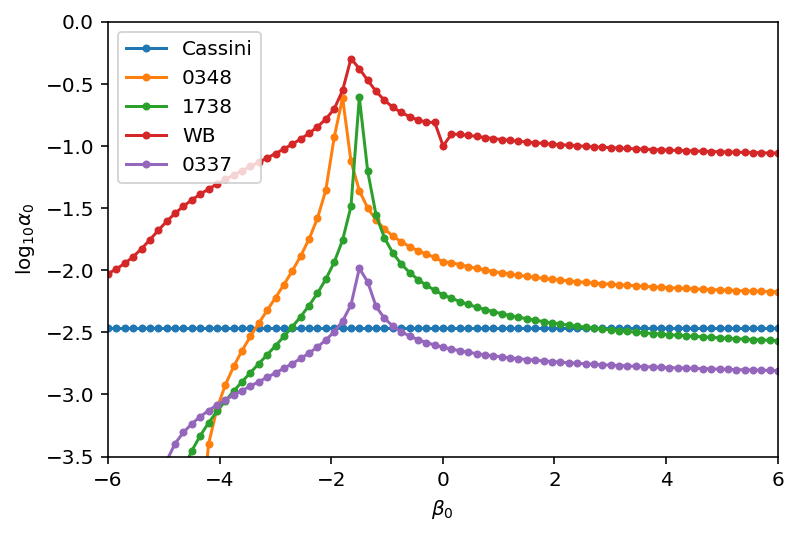

In [856]:
for name, betas, alphas in [
    ("Cassini", betas, alphas_cassini),
    ("0348", betas, alphas_0348),
    ("1738", betas, alphas_1738),
    ("WB", betas, alphas_existing_SEP),
    ("0337", betas, alphas_0337),
    ]:
    plt.plot(betas, np.log10(np.abs(alphas)), ".-", label=name)

plt.xlim(-6,6)
plt.ylim(-3.5,0)
plt.legend(loc="best")
plt.ylabel(r"$\log_{10}\alpha_0$")
plt.xlabel(r"$\beta_0$")
plt.savefig("alpha-beta-prototype.pdf")

In [857]:
d = dict(betas=betas,
         alphas={
             "0348": alphas_0348,
             "1738": alphas_1738,
             "WB": alphas_existing_SEP,
             "Cassini": alphas_cassini,
             "0337": alphas_0337,
         }
        )
with open("alpha-beta.pickle","wb") as f:
    pickle.dump(d,f)

In [858]:
ns_cache = {}
for k, alpha_map in all_map.items():
    for k2, mr_curve in alpha_map.items():
        for k3, d in mr_curve:
            ns_cache[d["initial"]] = d
print(len(ns_cache))
with open("ns_cache.pickle","wb") as f:
    pickle.dump(ns_cache, f)

452704


## Double checking for $\beta=-6$

In [840]:
#beta = betas[np.argmax(np.abs(alphas_existing_SEP))]
beta = betas[len(betas)//2]
mass = mass_existing_SEP
condition = condition_existing_SEP
beta

0.0050000000000007816

In [848]:
aa = eos_integrate.explore_beta(all_map, [beta], mass, condition)
aa

Exploring for beta=0.005000
1e-06 5.00603909506e-09
1 0.00500605766205
No spontaneous scalarization found
0 0 condition: -0.005
0 0 condition: -0.005
10.5556075392 10.5556075392 condition: -0.00337055927367
11.0812802614 11.0812802614 condition: -0.00272569630853
11.0812806684 11.0812806684 condition: -0.00272565445567
11.0812806697 11.0812806697 condition: -0.00272565295734
11.0812806697 11.0812806697 condition: -0.00272565295734
brentq with 11.0812806697 -0.00272565295734 11.0812806697 inf xtol 1e-12
11.0812806697 11.0812806697 condition: -0.00272565295734
returning 11.0812806697 0.0554417002938 -0.00272565295734


array([ 0.0554417])

In [809]:
eos_integrate.explore_alpha(all_map[beta], beta, mass, condition)

1e-06 -1.14575182479e-06
1 -2.28651923859
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.682542655047
0 0 condition: -0.005
1 1 condition: 0.682542655047
0.0483293023857 0.0483293023857 condition: -0.00373879681214
0.515700826872 0.515700826872 condition: -0.00187275478501
0.53040363982 0.53040363982 condition: -6.03865978055e-10
0.530406119414 0.530406119414 condition: 1.45180121541e-06
0.530403639822 0.530403639822 condition: 1.99943983245e-10
0.530403639821 0.530403639821 condition: -5.32548956322e-10
0.530403639821 0.530403639821 condition: -5.32548956322e-10
0.530403639822 0.530403639822 condition: 1.99943983245e-10
brentq with 0.530403639821 -5.32548956322e-10 0.530403639822 1.99943983245e-10 xtol 1e-12
0.530403639821 0.530403639821 condition: -5.32548956322e-10
0.530403639822 0.530403639822 condition: 1.99943983245e-10
returning 0.530403639822 -0.89448640848 1.99943983245e-10


{'Delta': -0.0050000001999439833,
 'I_A': -1.9464990540137698e+37,
 'J_A': -1.9464990038451893e+37,
 'Omega': 0.99999997422624975,
 'Q1': 1.3379600817736124,
 'Q2': 0.89405633953920904,
 'R': 19.616173748146583,
 'a': 0,
 'alpha_0': -0.89448640847951233,
 'alpha_A': -0.8888966083969787,
 'b': -2.5471249999999999,
 'beta_0': -2.5471249999999999,
 'initial': (6.701254825930502e+34, 0.5304036398217481, -2.5471249999999999),
 'm_A': 1.4000000002512825,
 'mb_A': 1.8580771707467361,
 'nu_hat': -0.23585428974780773,
 'nu_prime': 1.3504082034812001e-07,
 'phi_0': 0.35117491622103836,
 'rho_start': 1e-06}

In [849]:
alpha_map = all_map[beta]
for phi_c in np.exp(np.linspace(np.log(11.081), np.log(11.082), 20)):
    eos_integrate.try_alpha(alpha_map, phi_c, beta, mass)

In [850]:
#beta = -6
alpha_map = all_map[beta]
ds = []
for k in sorted(alpha_map.keys()):
    try:
        ds.append(eos_integrate.mr_curve(alpha_map[k], k, beta, mass))
    except eos_integrate.EOSError:
        print(k, "not possible")
phi_c_min = eos_integrate.find_scalarization(alpha_map, beta, mass)
phi_c_min

11.0812806697 not possible
11.0812806699 not possible
11.0812806701 not possible
11.0812806718 not possible
11.0812806752 not possible
11.0812807343 not possible
11.0812816851 not possible
11.0812835918 not possible
11.0812988501 not possible
11.0813157797 not possible
11.0813684106 not possible
11.0814210416 not possible
11.081473673 not possible
11.0815263045 not possible
11.0815429877 not possible
11.0815789364 not possible
11.0816315684 not possible
11.0816842008 not possible
11.0817368334 not possible
11.0817894662 not possible
11.0818420993 not possible
11.0818947326 not possible
11.0819473662 not possible
11.082 not possible
11.0820312679 not possible
11.0859375144 not possible
11.0937500126 not possible
11.1250000104 not possible
11.2500000064 not possible
11.5000000034 not possible
12.0000000025 not possible
16 not possible
1e-06 5.00603909506e-09
1 0.00500605766205
No spontaneous scalarization found


0

(-0.01, 0.01)

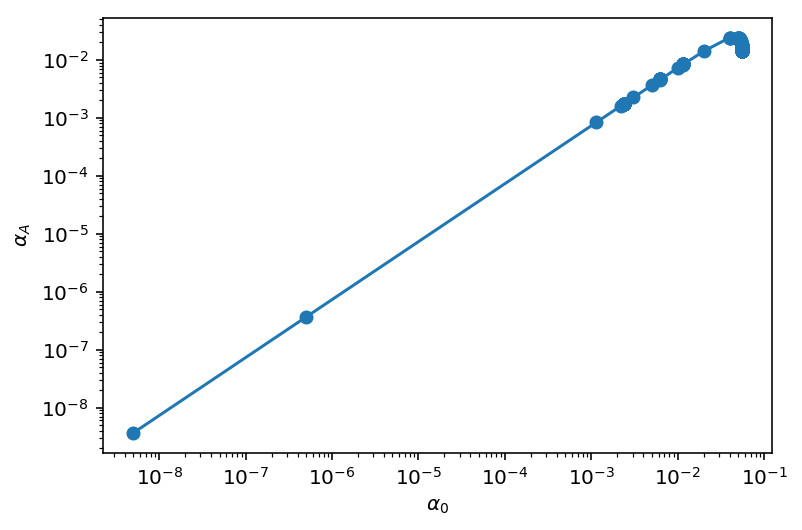

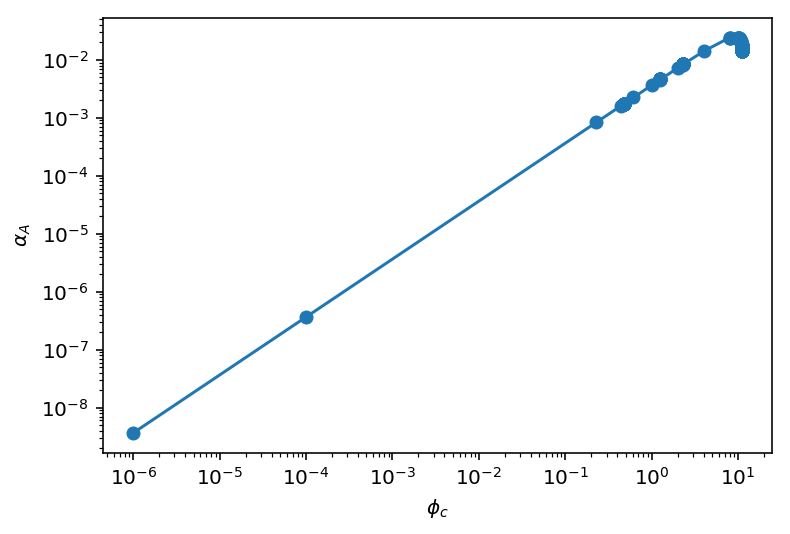

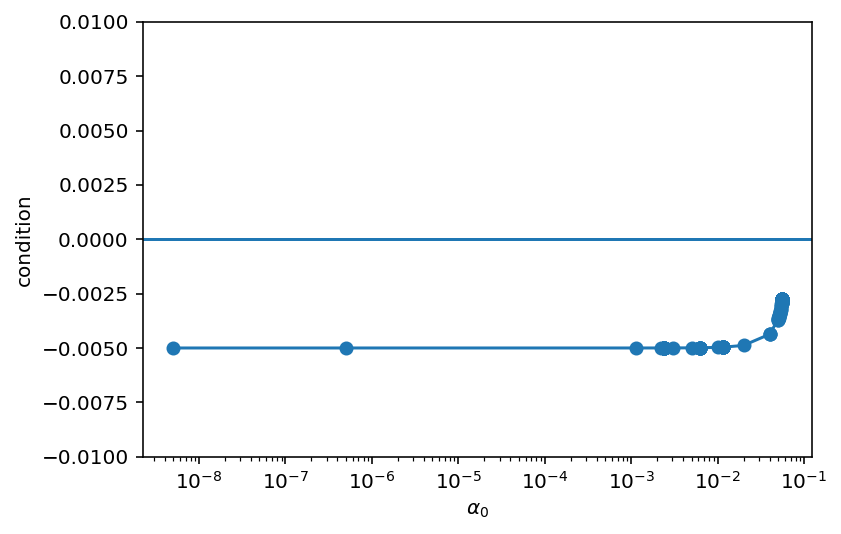

In [851]:
plt.loglog([abs(d["alpha_0"]) for d in ds if d["initial"][1]>phi_c_min],
           [abs(d["alpha_A"]) for d in ds if d["initial"][1]>phi_c_min],
           "o-")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\alpha_A$")
#plt.axhline(1.6e-6)
plt.figure()
plt.loglog([abs(d["initial"][1]-phi_c_min) for d in ds if d["initial"][1]>phi_c_min],
           [abs(d["alpha_A"]) for d in ds if d["initial"][1]>phi_c_min],
           "o-")
plt.xlabel(r"$\phi_c$")
plt.ylabel(r"$\alpha_A$")
#plt.axhline(1.6e-6)
plt.figure()

plt.semilogx([abs(d["alpha_0"]) for d in ds if d["initial"][1]>phi_c_min],
           [condition(d) for d in ds if d["initial"][1]>phi_c_min],
           "o-")
plt.axhline(0)
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"condition")
plt.ylim(-0.01,0.01)

## Checking the constraint behaviour

In [340]:
mass = mass_0348
beta = -5

if beta not in all_map:
    all_map[beta] = {}
alpha_map = all_map[beta]

phis = []
alpha_0s = []
alpha_As = []

for phi_c in sorted(alpha_map):
    print(phi_c)
    d = eos_integrate.mr_curve(alpha_map[phi_c], phi_c, beta, mass) 
    phis.append(phi_c)
    alpha_0s.append(d["alpha_0"])
    alpha_As.append(d["alpha_A"])
    
phis = np.array(phis)
alpha_0s = np.array(alpha_0s)
alpha_As = np.array(alpha_As)

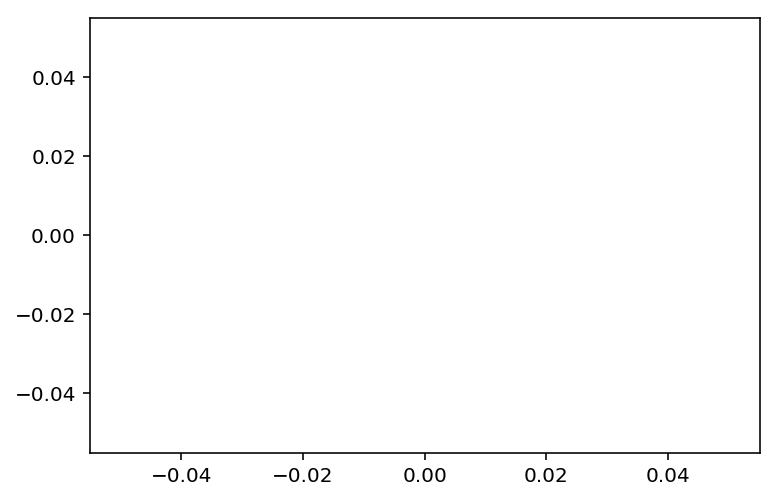

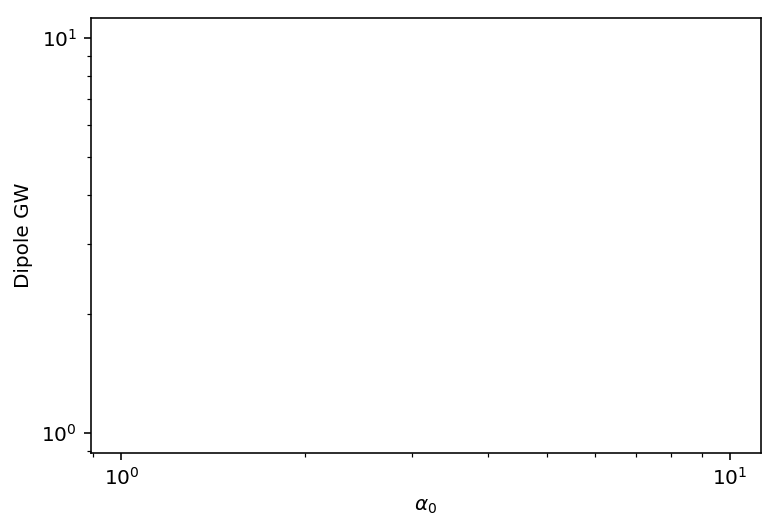

In [341]:
plt.plot(phis, alpha_0s)
plt.plot(phis, alpha_As)
plt.figure()
plt.loglog(alpha_0s, np.abs(alpha_As-alpha_0s))
plt.xlabel(r"$\alpha_0$")
plt.ylabel("Dipole GW")

In [447]:
phi_c = 0.2e-3
beta = -5
mr = []
d = eos_integrate.mr_curve(mr, phi_c, beta, mass)
np.abs(d["alpha_0"]) ,np.abs(d["alpha_A"])

(0.00010415328624231039, 0.0004256220413308578)

In [504]:
phi_c = 0.5
beta = -5
mr2 = []
d = eos_integrate.mr_curve(mr2, phi_c, beta, mass)
np.abs(d["alpha_0"]) ,np.abs(d["alpha_A"])

(1.2325626474920834, 1.2785514074907005)

In [464]:
phi_c = 8e-2
beta = -1
mr3 = []
d = eos_integrate.mr_curve(mr3, phi_c, beta, mass)
np.abs(d["alpha_0"]) ,np.abs(d["alpha_A"])

(0.058344099706410024, 0.044284977965885708)

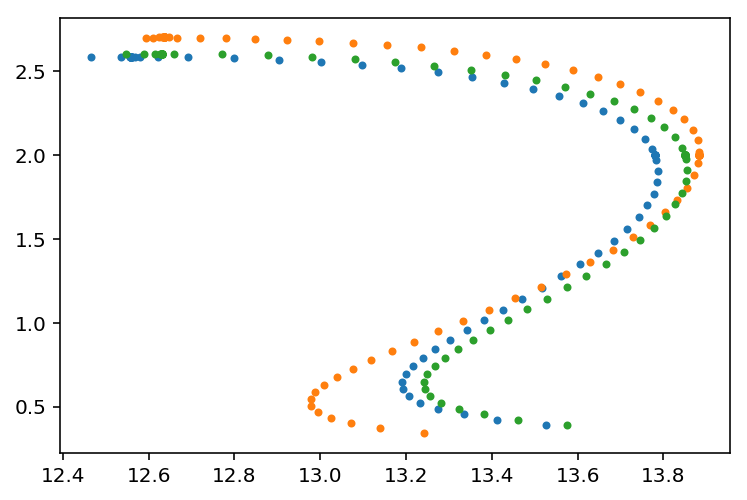

In [465]:
xs = []
ys = []
for pc, d in mr:
    xs.append(d["R"])
    ys.append(d["m_A"])
xs2 = []
ys2 = []
for pc, d in mr2:
    xs2.append(d["R"])
    ys2.append(d["m_A"])
xs3 = []
ys3 = []
for pc, d in mr3:
    xs3.append(d["R"])
    ys3.append(d["m_A"])
plt.plot(xs, ys, ".")
plt.plot(xs2, ys2, ".")
plt.plot(xs3, ys3, ".")


In [367]:
# Figure 4 of 0348 paper
beta = -5

if beta not in all_map:
    all_map[beta] = {}
alpha_map = all_map[beta]

ms = np.linspace(0.4,2.4,10)
alpha_As = []
for m in ms:
    print("Evaluating",m)
    d = eos_integrate.explore_alpha(alpha_map, beta, m, 
                                    lambda d: -d["alpha_0"]-1e-4)
    alpha_As.append(d["alpha_A"])
alpha_As = np.array(alpha_As)

Evaluating 0.4
1.953125e-06 -9.45729679921e-05
Starting search
1.953125e-06 -9.45729679921e-05
Bisection searching
0.000201776697526 0.000460664914505
7.41742480885e-05 0.000106103567507
3.5987023067e-05 -5.00178829103e-09
5.01204304013e-05 3.92666504657e-05
3.59888235082e-05 9.15227434312e-13
bisection found 3.5987023067e-05 3.59888235082e-05
3.59888235082e-05 9.15227434312e-13
Bracketing done 3.5987023067e-05 3.59888235082e-05
3.5987023067e-05 -5.00178829103e-09
3.59888235082e-05 9.15227434312e-13
3.5987023067e-05 -5.00178829103e-09
3.59888235082e-05 9.15227434312e-13
Evaluating 0.622222222222
1.953125e-06 -9.61031361779e-05
Starting search
1.953125e-06 -9.61031361779e-05
Bisection searching
0.000201776697526 0.000302583786848
7.41742480885e-05 4.79920428214e-05
3.5987023067e-05 -2.81988950205e-05
5.01204304013e-05 -1.64853699268e-13
5.01229374228e-05 5.00190440998e-09
bisection found 5.01204304013e-05 5.01229374228e-05
5.01229374228e-05 5.00190440998e-09
Bracketing done 5.0120430401

AlphaProblem: Integration problems prevent condition being met

In [ ]:
plt.plot(ms, alpha_As)

## Spontaneous scalarization, where is it?

In [492]:
phi_c = 1
beta = -5
mr = []
d = eos_integrate.mr_curve(mr, phi_c, beta, mass_0348)
np.abs(d["alpha_0"]) ,np.abs(d["alpha_A"])

(4.7520576398969165, 4.1006113194158447)

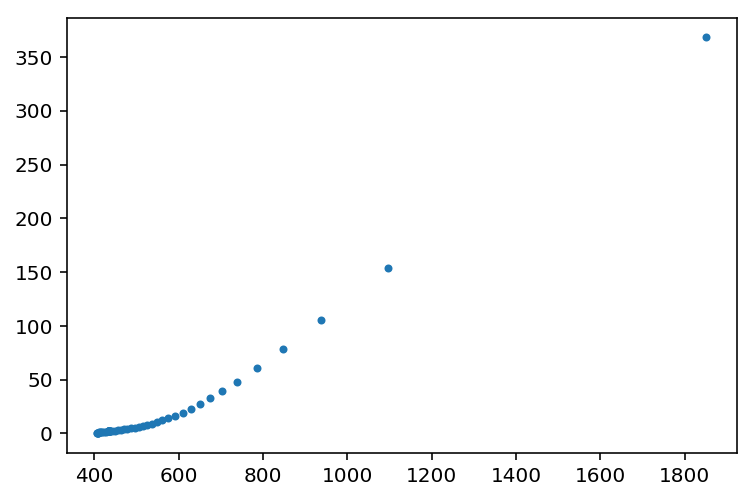

In [493]:
xs = []
ys = []
for pc, d in mr:
    xs.append(d["R"])
    ys.append(d["m_A"])
plt.plot(xs, ys, ".")

In [494]:
p_c, phi_c, beta = d["initial"]
N = eos_integrate.NeutronStar(a=0, b=beta)
rs, xs = N.integrate(p_c = p_c, phi_c = phi_c)
rs = np.array(rs)
xs = np.array(xs)
M, nu, phi, psi, p, Mb, omega, omicron = xs.T
A_phi = np.array([N.A(phii) for phii in phi])
e = np.array([N.energy_density(pi) for pi in p])
a_phi = N.a + N.b*phi

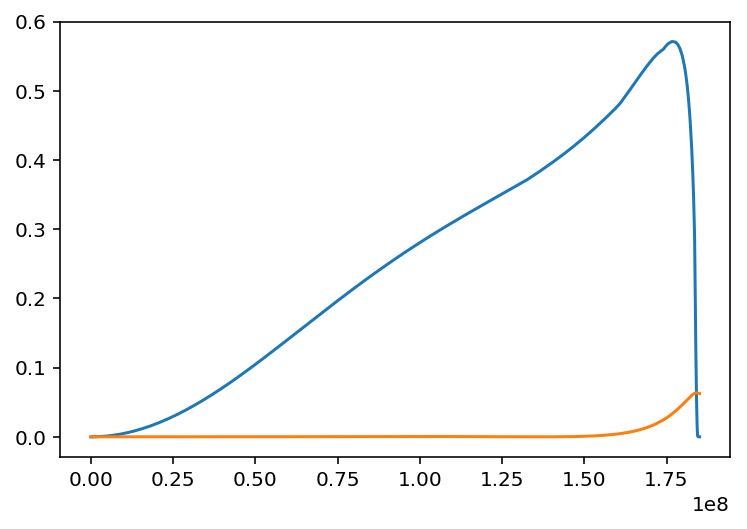

In [495]:
# M_prime terms
plt.plot(rs, (4*np.pi*eos_integrate.G/eos_integrate.c**4*rs**2
              *A_phi**4*e))                                                                    
plt.plot(rs, rs*(rs-2*M)*psi**2/2)


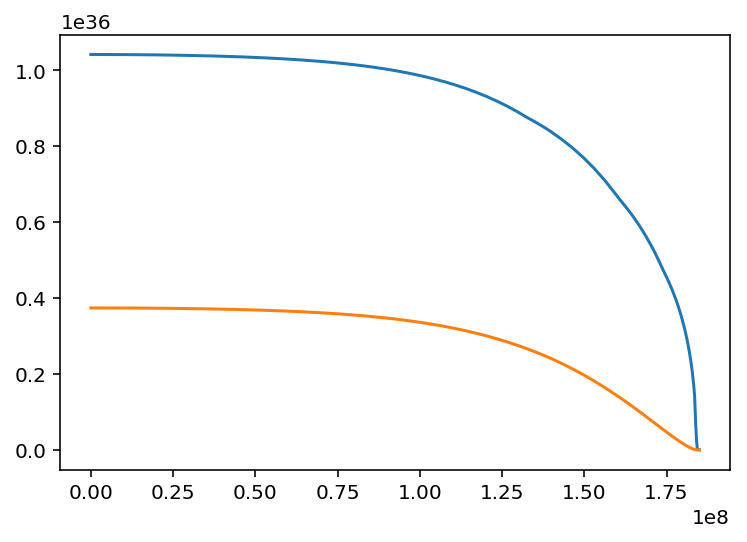

In [496]:
plt.plot(rs, e)
plt.plot(rs, p)

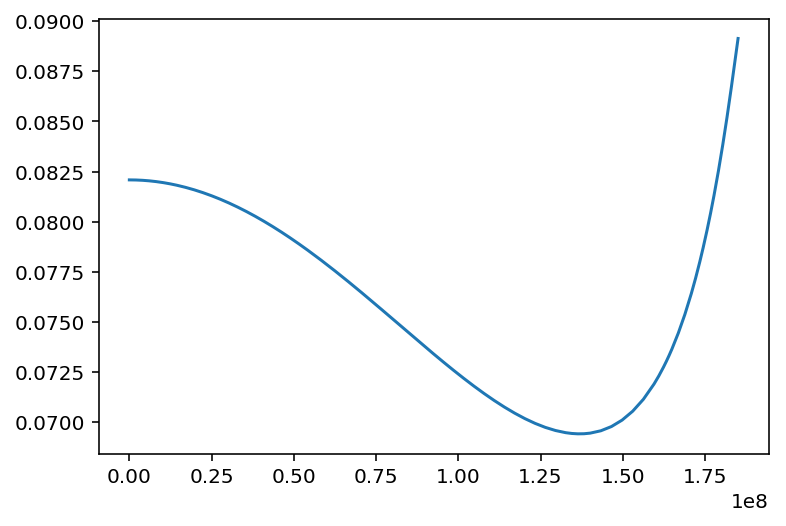

In [497]:
plt.plot(rs, A_phi)

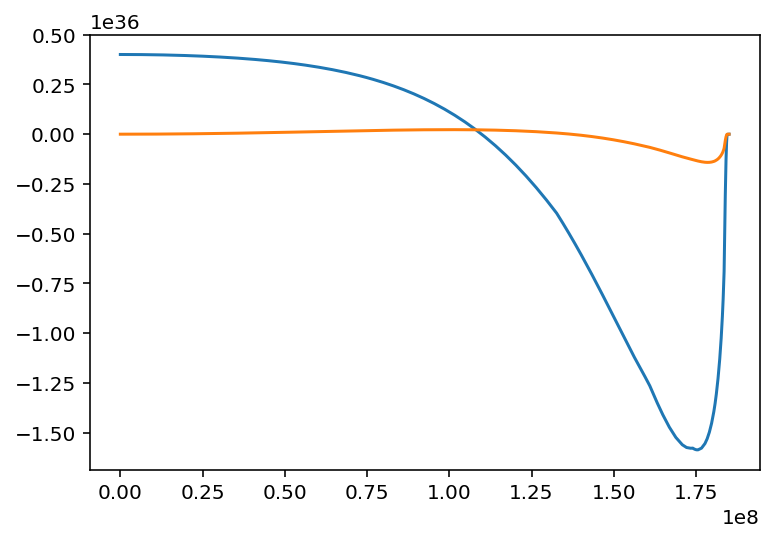

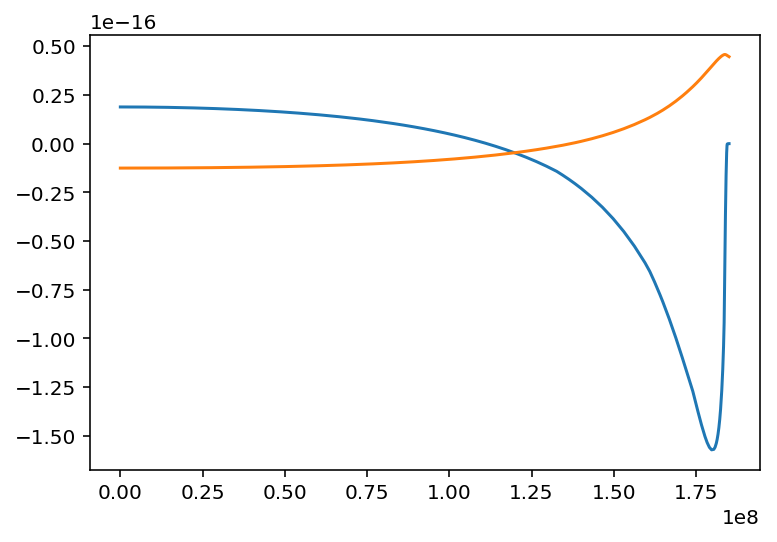

In [498]:
# psi_prime terms
plt.plot(rs, a_phi*(e-3*p))
plt.plot(rs, rs*psi*(e-p))
plt.figure()
plt.plot(rs, 4*np.pi*eos_integrate.G/eos_integrate.c**4
             * rs*A_phi**4/(rs-2*M)
             * (a_phi*(e-3*p)+rs*psi*(e-p)))
plt.plot(rs, - 2*(rs-M)*psi/(rs*(rs-2*M)))

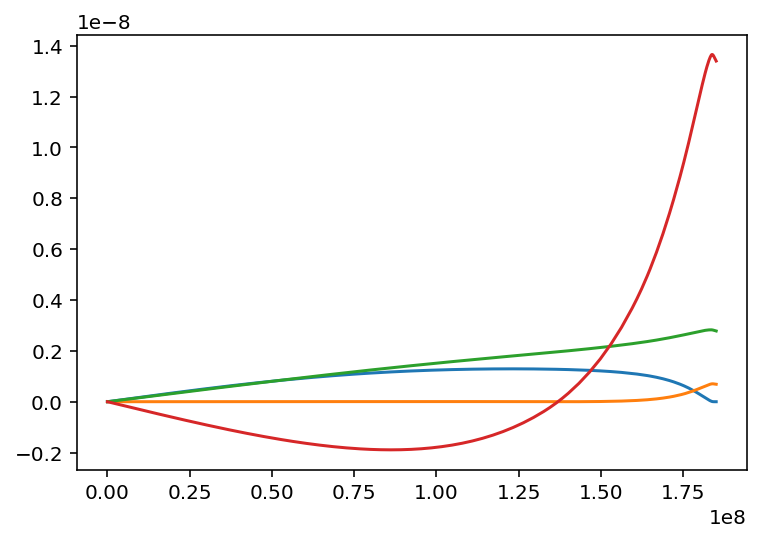

In [499]:
# p terms
plt.plot(rs, 4*np.pi*eos_integrate.G/eos_integrate.c**4
             *rs**2*A_phi**4*p/(rs-2*M))
plt.plot(rs, rs*psi**2/2)
plt.plot(rs, M/(rs*(rs-2*M)))
plt.plot(rs, a_phi*psi)
        

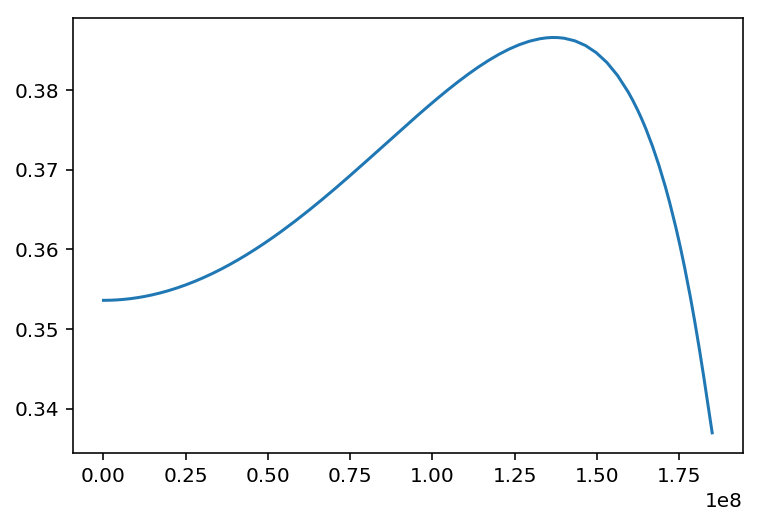

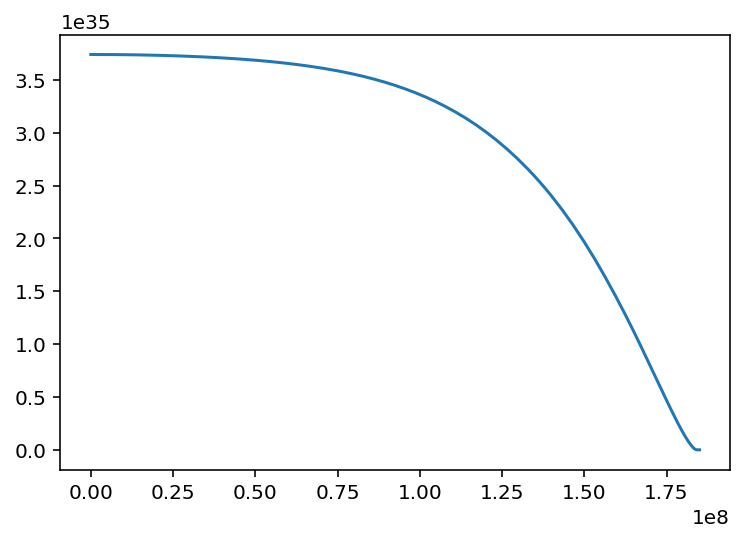

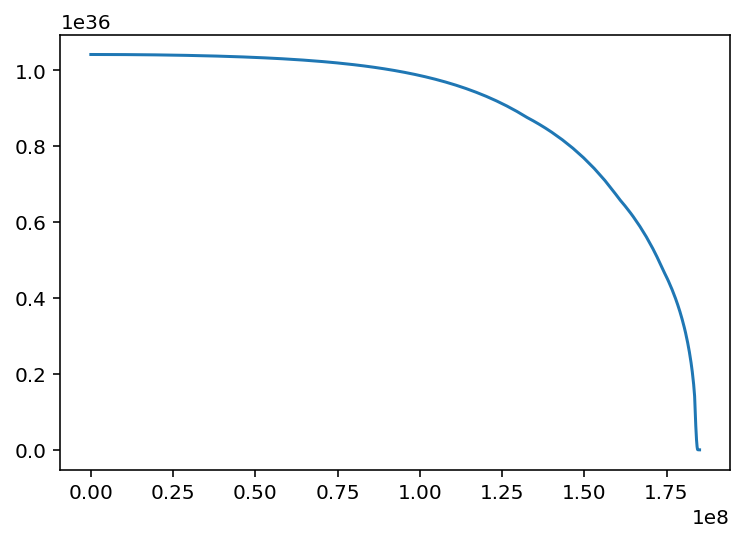

In [500]:
plt.plot(rs, phi-N.phi_0)
plt.figure()
plt.plot(rs, p)
plt.figure()
plt.plot(rs, [N.energy_density(pi) for pi in p])

In [501]:
p_c, phi_c, beta = d["initial"]
N = eos_integrate.NeutronStar(a=0, b=beta)
rs, xs = N.integrate(p_c = p_c, phi_c = phi_c)
rs = np.array(rs)
xs = np.array(xs)
M, nu, phi, psi, p, Mb, omega, omicron = xs.T

N2 = eos_integrate.NeutronStar(a=0, b=beta)
rs2, xs2 = N2.integrate(p_c = p_c, phi_c = 0.4)
rs2 = np.array(rs2)
xs2 = np.array(xs2)
M2, nu2, phi2, psi2, p2, Mb2, omega2, omicron2 = xs2.T

phi_c

1

-5

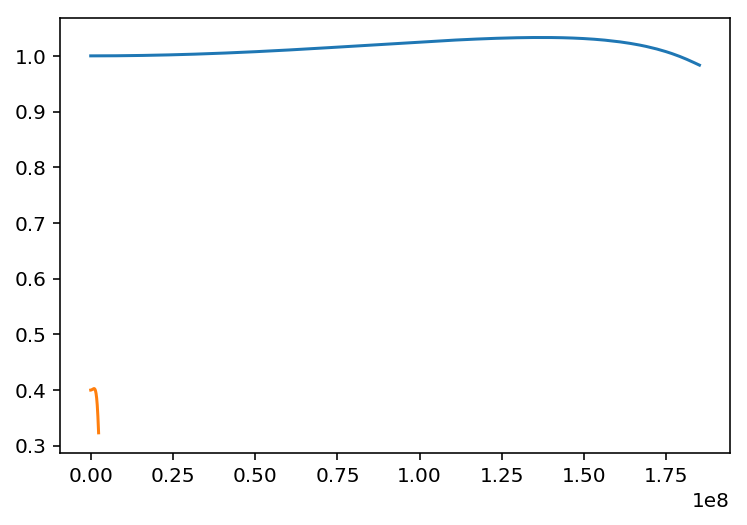

In [502]:
plt.plot(rs, phi)
plt.plot(rs2, phi2)
beta

In [441]:
rs[-1]-rs[-2]

0.0

In [444]:
# Figure 1 of de96
dd = eos_integrate.evaluate(p_c,phi_c,beta)
dd["phi_0"], dd["alpha_0"], dd["alpha_A"]

(-0.0048155617554606345, 0.024077808777303172, -0.10665665069520933)

In [552]:
phi_cs = np.exp(np.linspace(np.log(1e-1),np.log(1),40))
ds = [eos_integrate.mr_curve([],phi_c,-6, mass_0348) 
      for phi_c in phi_cs]

(2, 3)

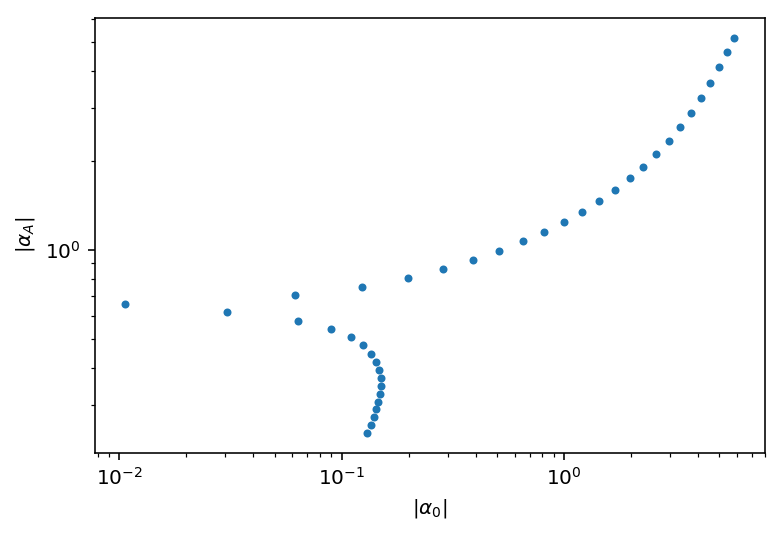

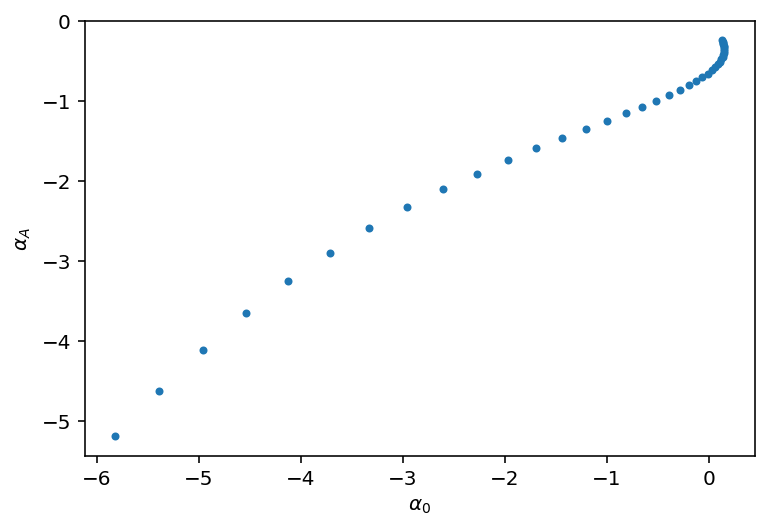

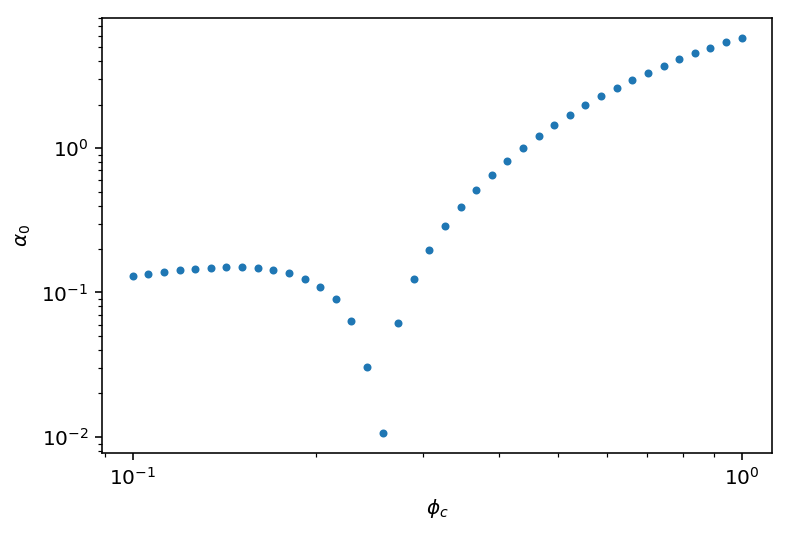

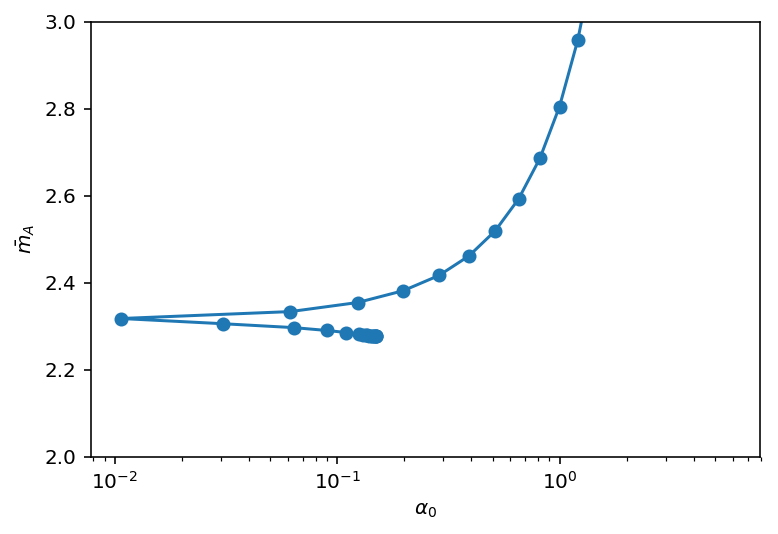

In [554]:
plt.loglog([abs(d["alpha_0"]) for d in ds],
         [abs(d["alpha_A"]) for d in ds], ".")
plt.xlabel(r"$|\alpha_0|$")
plt.ylabel(r"$|\alpha_A|$")
plt.figure()
plt.plot([(d["alpha_0"]) for d in ds],
         [(d["alpha_A"]) for d in ds], ".")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\alpha_A$")
plt.figure()
plt.loglog(phi_cs,
           [abs(d["alpha_0"]) for d in ds], ".")
plt.xlabel(r"$\phi_c$")
plt.ylabel(r"$\alpha_0$")
plt.figure()
plt.semilogx([abs(d["alpha_0"]) for d in ds],
         [abs(d["mb_A"]) for d in ds], "o-")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\bar m_A$")
plt.ylim(2,3)

In [522]:
pickle.dump?

In [521]:
import pickle

## Exploring where spontaneous scalarization occurs

In [622]:
all_map = {}

In [642]:
beta = -1
mass = mass_0348

if beta not in all_map:
    all_map[beta] = {}
scalar_phi = eos_integrate.find_scalarization(all_map[beta], beta, mass)

0.0001 -7.28637489627e-05
1 -0.852302302118


In [643]:
mass = mass_0337
condition = condition_0337
scalar_phi = eos_integrate.find_scalarization(all_map[beta], beta, mass)
d = eos_integrate.explore_alpha(all_map[beta], beta, mass, condition)
d

0.0001 -7.6515575198e-05
1 -0.880694515618
0.0001 -7.6515575198e-05
1 -0.880694515618
0 condition: -1.6e-06
1 condition: 0.0858074956864
0 condition: -1.6e-06
1 condition: 0.0858074956864
0.0001 condition: -1.59938404927e-06
0.0001 condition: -1.59938404927e-06
1 condition: 0.0858074956864
brentq with 0.0001 -1.59938404927e-06 1 0.0858074956864
0.0001 condition: -1.59938404927e-06
1.0 condition: 0.0858074956864
0.00011863700007 condition: -1.5991330655e-06
0.118861325273 condition: 0.000873957138593
0.000335510963802 condition: -1.5930663895e-06
0.0571814664625 condition: 0.000200080460905
0.000784550469875 condition: -1.56208702574e-06
0.0232512762883 condition: 3.17074215119e-05
0.00183941970163 condition: -1.39159493558e-06
0.0100875035443 condition: 4.66804999428e-06
0.00373358872252 condition: -7.41378818088e-07
0.00559732844395 condition: 3.29805110985e-07
0.00502350459448 condition: -4.55944146317e-08
0.00509319877556 condition: -2.16435968394e-09
0.0050966493771 condition: 1.43

{'Delta': -1.6000014313110808e-06,
 'I_A': 5.5548773491536225e+37,
 'J_A': 5.554877433041515e+37,
 'Omega': 1.0000000151016641,
 'Q1': 1.0000060881758677,
 'Q2': 0.83036484641709329,
 'R': 13.657143568676775,
 'a': 0,
 'alpha_0': -0.0038997512184057418,
 'alpha_A': -0.0034894682691346398,
 'b': -1,
 'beta_0': -1,
 'initial': (6.269867580732077e+34, 0.005096649377103543, -1),
 'm_A': 1.4378000000507549,
 'mb_A': 1.5757733448171813,
 'nu_hat': -0.37178067969001799,
 'nu_prime': 3.2972838316543817e-07,
 'phi_0': 0.0038997512184057418,
 'rho_start': 1e-06}

In [644]:
alpha_map = all_map[beta]
ds = []
for phi_c in sorted(alpha_map.keys()):
    try:
        ds.append(eos_integrate.mr_curve(alpha_map[phi_c], phi_c, beta, mass))
    except eos_integrate.EOSError:
        pass

-1

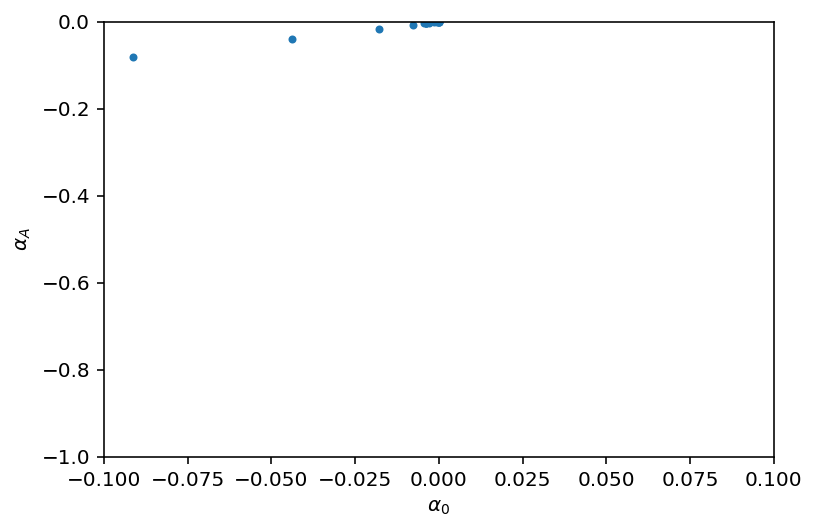

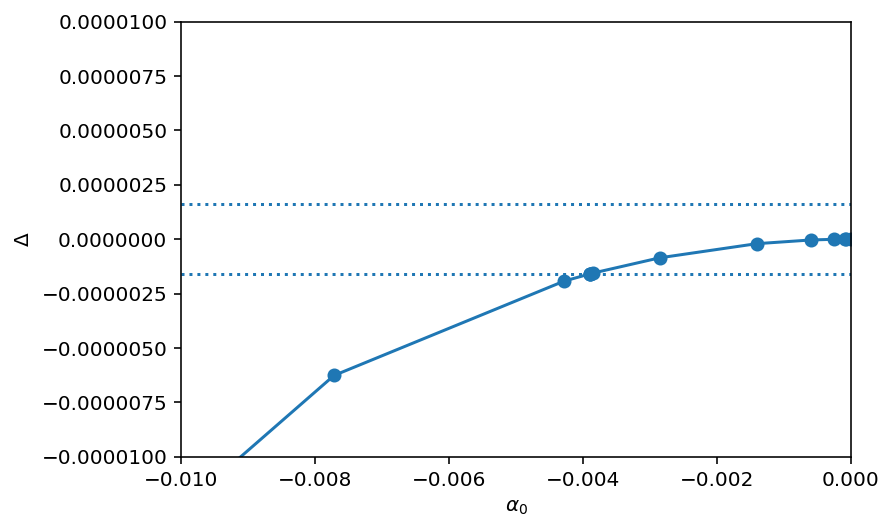

In [649]:
plt.plot([(d["alpha_0"]) for d in ds if d["initial"][1]>=scalar_phi],
         [(d["alpha_A"]) for d in ds if d["initial"][1]>=scalar_phi], ".")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\alpha_A$")
plt.xlim(-0.1,0.1)
plt.ylim(-1,0)
plt.figure()
plt.plot([(d["alpha_0"]) for d in ds if d["initial"][1]>=scalar_phi],
         [(d["Delta"]) for d in ds if d["initial"][1]>=scalar_phi], 
         "o-")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\Delta$")
plt.axhline(1.6e-6,linestyle=":")
plt.axhline(-1.6e-6,linestyle=":")
plt.ylim(-1e-5,1e-5)
plt.xlim(-1e-2,0)
beta

In [646]:
beta

-1

In [647]:
scalar_phi

0

In [648]:
d

{'Delta': -0.085809095686351242,
 'I_A': -1.1034227274560479e+40,
 'J_A': -1.103422583827089e+40,
 'Omega': 0.99999986983324218,
 'Q1': 1.2702353772323556,
 'Q2': 0.92218447183186658,
 'R': 27.625395447972895,
 'a': 0,
 'alpha_0': -0.88069451561757184,
 'alpha_A': -0.78326107625275521,
 'b': -1,
 'beta_0': -1,
 'initial': (3.4527346740628564e+34, 1, -1),
 'm_A': 1.4377999999539155,
 'mb_A': 2.2897787643016803,
 'nu_hat': -0.16651543307788805,
 'nu_prime': 6.5484338332231337e-08,
 'phi_0': 0.88069451561757184,
 'rho_start': 1e-06}